In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import requests
import time
import ast
import calendar
from dateutil.relativedelta import relativedelta

# Plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
import plotly.express as px
from matplotlib.colors import Normalize, ListedColormap
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import AutoMinorLocator
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D
from matplotlib.dates import MonthLocator, YearLocator, DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Statistics and Preprocessing
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Machine Learning Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Evaluation and Tuning
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error

seed = 101

---

# USA National Park Trails

In [2]:
usaTrails = pd.read_csv("data/alltrails-data.csv", engine="python", encoding="latin1")

numUsaTrailsUnfiltered = len(usaTrails)
print(f"Number of USA national park trails (unfiltered): {numUsaTrailsUnfiltered}")

Number of USA national park trails (unfiltered): 3313


### Renaming Columns

In [3]:
usaTrails.columns

Index(['trail_id', 'name', 'area_name', 'city_name', 'state_name',
       'country_name', '_geoloc', 'popularity', 'length', 'elevation_gain',
       'difficulty_rating', 'route_type', 'visitor_usage', 'avg_rating',
       'num_reviews', 'features', 'activities', 'units'],
      dtype='object')

In [4]:
usaTrails = usaTrails.rename(columns={
    "length": "distance",
    "difficulty_rating": "difficulty",
    "avg_rating": "enjoyment",
    "area_name": "park",
    "city_name": "city",
    "state_name": "province",
    "country_name": "country",
    "_geoloc": "location",
    "name": "trail_name"
})

### Parsing latitude and longitude from location

In [5]:
usaTrails.location.head()

0    {'lat': 60.18852, 'lng': -149.63156}
1    {'lat': 63.73049, 'lng': -148.91968}
2      {'lat': 60.18879, 'lng': -149.631}
3      {'lat': 63.73661, 'lng': -148.915}
4    {'lat': 63.73319, 'lng': -148.89682}
Name: location, dtype: object

In [6]:
usaTrails["latitude"] = usaTrails.apply(lambda trail: trail.location.split(': ', 2)[1][:-7], axis=1)
usaTrails["longitude"] = usaTrails.apply(lambda trail: trail.location.split(': ', 2)[2][:-1], axis=1)
usaTrails = usaTrails.drop("location", axis=1)

### Columns from Trail Features

In [7]:
usaTrails.features.head()

0    ['dogs-no', 'forest', 'river', 'views', 'water...
1    ['dogs-no', 'forest', 'views', 'wild-flowers',...
2    ['dogs-no', 'partially-paved', 'views', 'wildl...
3    ['dogs-no', 'forest', 'lake', 'kids', 'views',...
4    ['dogs-no', 'lake', 'views', 'wild-flowers', '...
Name: features, dtype: object

In [8]:
def getUsaRatios(column):
    return (usaTrails[column]
            .apply(ast.literal_eval)
            .explode()
            .reset_index()
            .drop_duplicates()
            .groupby(column).index
            .nunique()
            / len(usaTrails)
        ).sort_values(ascending=False)

getUsaRatios("features")

features
views              0.897676
dogs-no            0.731361
wildlife           0.665258
wild-flowers       0.626019
forest             0.606399
kids               0.329611
river              0.291880
lake               0.249019
waterfall          0.167824
dogs-leash         0.126773
beach              0.038032
ada                0.031391
partially-paved    0.030486
historic-site      0.029580
strollers          0.027769
hot-springs        0.027468
paved              0.022336
cave               0.022034
dogs               0.006339
rails-trails       0.001509
city-walk          0.001207
Name: index, dtype: float64

In [9]:
usaTrails["forest"] = usaTrails.features.str.contains("forest").astype(int)
usaTrails["river"] = usaTrails.features.str.contains("river").astype(int)
usaTrails["lake"] = usaTrails.features.str.contains("lake").astype(int)
usaTrails["waterfall"] = usaTrails.features.str.contains("waterfall").astype(int)
usaTrails["beach"] = usaTrails.features.str.contains("beach").astype(int)
usaTrails["historic_site"] = usaTrails.features.str.contains("historic-site").astype(int)
usaTrails["hot_spring"] = usaTrails.features.str.contains("hot-springs").astype(int)
usaTrails["cave"] = usaTrails.features.str.contains("cave").astype(int)

usaTrails = usaTrails.drop("features", axis=1)

### Columns from Trail Activities

In [10]:
usaTrails.activities.head()

0    ['birding', 'camping', 'hiking', 'nature-trips...
1    ['birding', 'camping', 'hiking', 'nature-trips...
2                                ['hiking', 'walking']
3    ['birding', 'hiking', 'nature-trips', 'trail-r...
4    ['birding', 'fishing', 'hiking', 'nature-trips...
Name: activities, dtype: object

In [11]:
getUsaRatios("activities")

activities
hiking                  0.937217
nature-trips            0.729248
birding                 0.596740
walking                 0.489586
trail-running           0.335044
backpacking             0.259885
camping                 0.258678
horseback-riding        0.081799
fishing                 0.059463
snowshoeing             0.044371
rock-climbing           0.032599
mountain-biking         0.028675
fly-fishing             0.025053
scenic-driving          0.024449
off-road-driving        0.022336
cross-country-skiing    0.016299
road-biking             0.015092
canoeing                0.015092
paddle-sports           0.014187
whitewater-kayaking     0.007848
skiing                  0.006641
snowboarding            0.003320
bike-touring            0.003018
sea-kayaking            0.002415
rails-trails            0.001509
ice-climbing            0.001509
surfing                 0.000906
Name: index, dtype: float64

In [12]:
usaTrails = usaTrails[usaTrails.activities.str.contains("hiking")] # I only care about hiking trails
usaTrails["backpacking"] = usaTrails.activities.str.contains("backpacking").astype(int)

usaTrails = usaTrails.drop("activities", axis=1)

### Cleaning city, park, province, and country

In [13]:
usaTrails.country.value_counts()

country
United States    3056
Hawaii             49
Name: count, dtype: int64

In [14]:
def suggestRemovalOfCategoricalFeatures(trails, categoricalFeatures, thresholdRatio=0.05):

    for feature in categoricalFeatures:
        counts = trails[feature].value_counts(normalize=True)
        rareCategories = counts[counts < thresholdRatio]
        rareFraction = rareCategories.sum()

        print(f"\n{feature}")
        print(f"  Total categories: {counts.size}")
        print(f"  Rare categories (<{thresholdRatio * 100:.0f}% of rows): {len(rareCategories)}")
        print(f"  Fraction of all rows in rare categories: {rareFraction:.2f}")

        if rareFraction > 0.5:
            print("  Suggestion: Remove, more than 50% of rows are in rare categories")
        else:
            print("  Suggestion: Keep")


suggestRemovalOfCategoricalFeatures(usaTrails, ["country", "province", "park", "city"])
pass


country
  Total categories: 2
  Rare categories (<5% of rows): 1
  Fraction of all rows in rare categories: 0.02
  Suggestion: Keep

province
  Total categories: 29
  Rare categories (<5% of rows): 20
  Fraction of all rows in rare categories: 0.21
  Suggestion: Keep

park
  Total categories: 58
  Rare categories (<5% of rows): 51
  Fraction of all rows in rare categories: 0.53
  Suggestion: Remove, more than 50% of rows are in rare categories

city
  Total categories: 264
  Rare categories (<5% of rows): 262
  Fraction of all rows in rare categories: 0.88
  Suggestion: Remove, more than 50% of rows are in rare categories


In [15]:
usaTrails.province.value_counts()

province
California        658
Washington        312
Wyoming           286
Colorado          256
Utah              254
Virginia          185
Maine             172
Tennessee         167
Arizona           163
Montana           147
North Carolina    114
Texas              78
Ohio               49
Hawaii             35
Alaska             29
Kentucky           27
Nevada             25
North Dakota       23
Oregon             21
Florida            20
South Dakota       19
Maui               14
Indiana            14
Arkansas           14
Minnesota           7
New Mexico          7
South Carolina      4
Michigan            4
Georgia             1
Name: count, dtype: int64

In [16]:
usaTrails.park.value_counts()

park
Great Smoky Mountains National Park                281
Yosemite National Park                             230
Yellowstone National Park                          215
Rocky Mountain National Park                       204
Shenandoah National Park                           183
Acadia National Park                               172
Olympic National Park                              163
Mount Rainier National Park                        129
Glacier National Park                              128
Joshua Tree National Park                           98
Grand Canyon National Park                          94
Grand Teton National Park                           90
Zion National Park                                  88
Sequoia National Park                               88
Canyonlands National Park                           63
Death Valley National Park                          61
Kings Canyon National Park                          58
Big Bend National Park                              57
Lasse

In [17]:
usaTrails["country"] = "USA" # All are part of USA

usaTrails.loc[usaTrails["province"] == "Maui", "province"] = "Hawaii" # Maui is part of Hawaii

usaTrails["park"] = usaTrails.park.str.replace(" National Park", "") # Shortening park names

usaTrails = usaTrails.drop(["city"], axis=1) # High cardinality, removing city

### Cleaning distance and elevation_gain

In [18]:
usaTrails.units.unique()

array(['i', 'm'], dtype=object)

In [19]:
usaTrails.query("units == 'm'")[["trail_name", "distance", "elevation_gain", "units"]].head()

trail_name   distance  \
3264         Kilauea Iki Trail and Crater Rim Trail   4828.020   
3265                          Kalapana Lava Viewing  15288.730   
3266           Pu'u Huluhulu via Napau Crater Trail   4023.350   
3267  Halemaâumaâu Steam Bluff and Sulfur Banks   2092.142   
3268                      Puu Loa Petroglyphs Trail   1931.208   

      elevation_gain units  
3264        209.7024     m  
3265        196.9008     m  
3266         94.7928     m  
3267         24.9936     m  
3268         25.9080     m

In [20]:
usaTrails.query("units == 'i'")[["trail_name", "distance", "elevation_gain", "units"]].head()

trail_name   distance  elevation_gain units
0     Harding Ice Field Trail  15610.598       1161.8976     i
1  Mount Healy Overlook Trail   6920.162        507.7968     i
2          Exit Glacier Trail   2896.812         81.9912     i
3        Horseshoe Lake Trail   3379.614        119.7864     i
4          Triple Lakes Trail  29772.790       1124.7120     i

In [21]:
usaTrails["distance"] = usaTrails.distance/1000 # m to km

### Validating Data Ranges

In [22]:
usaTrails.describe()

trail_id   popularity     distance  elevation_gain   difficulty  \
count  3.105000e+03  3105.000000  3105.000000     3105.000000  3105.000000   
mean   1.018488e+07     9.135155    16.126209      634.816924     3.226731   
std    1.495558e+05     8.274155    21.251747      898.523793     1.698277   
min    1.000001e+07     0.000000     0.000000        0.000000     1.000000   
25%    1.002819e+07     3.848900     4.506152      120.700800     1.000000   
50%    1.023621e+07     6.715900    10.299776      359.968800     3.000000   
75%    1.029199e+07    11.470700    20.116750      821.740800     5.000000   
max    1.054512e+07    84.622900   339.570740    14029.944000     7.000000   

       visitor_usage    enjoyment  num_reviews       forest        river  \
count    2870.000000  3105.000000  3105.000000  3105.000000  3105.000000   
mean        1.882230     4.185346    73.040580     0.625765     0.293076   
std         0.695099     0.930508   188.726238     0.484003     0.455246   
min         1.000000     0.000000     0.000000     0.000000     0.000000   
25%         1.000000     4.000000     6.000000     0.000000     0.000000   
50%         2.000000     4.500000    18.000000     1.000000     0.000000   
75%         2.000000     4.500000    60.000000     1.000000     1.000000   
max         4.000000     5.000000  3903.000000     1.000000     1.000000   

              lake    waterfall        beach  historic_site   hot_spring  \
count  3105.000000  3105.000000  3105.000000    3105.000000  3105.000000   
mean      0.253462     0.173591     0.037359       0.028019     0.026731   
std       0.435063     0.378818     0.189671       0.165055     0.161322   
min       0.000000     0.000000     0.000000       0.000000     0.000000   
25%       0.000000     0.000000     0.000000       0.000000     0.000000   
50%       0.000000     0.000000     0.000000       0.000000     0.000000   
75%       1.000000     0.000000     0.000000       0.000000     0.000000   
max       1.000000     1.000000     1.000000       1.000000     1.000000   

              cave  backpacking  
count  3105.000000  3105.000000  
mean      0.021900     0.268599  
std       0.146381     0.443302  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       0.000000     0.000000  
75%       0.000000     1.000000  
max       1.000000     1.000000

In [23]:
# Make sure to not to use enjoyment == 0 for predicting enjoyment, they were not reviewed
usaTrails.query("num_reviews == 0")[["trail_name", "num_reviews", "difficulty", "enjoyment"]].head()

trail_name  num_reviews  \
26                                Eldorado Creek Trail            0   
196                                     Schmutz Spring            0   
198  Arizona Trail: Savilla Campground to Saguaro N...            0   
200                     North Bass Trail to Muav Cabin            0   
745        Twin Lakes, Horseshoe Lake, and Summit Lake            0   

     difficulty  enjoyment  
26            3        0.0  
196           3        0.0  
198           3        0.0  
200           1        0.0  
745           3        0.0

In [24]:
usaTrails = usaTrails.query("distance > 0") # These features can not be 0

### Adding user to usaTrails

In [25]:
usaTrails["user"] = "AllTrails"

### Adding Previously Processed Climate Data

In [26]:
usaTrailClimates = pd.read_csv("data/alltrails-climate.csv", engine="python", encoding="latin1")

usaTrails = usaTrails.merge(usaTrailClimates, on="trail_id", how="left")

### Removing Useless Columns

In [27]:
usaTrails = usaTrails.drop(["trail_id", "popularity", "visitor_usage", "units", "num_reviews"], axis=1)

### Handling Null Values

In [28]:
usaTrails.isna().sum()

trail_name        0
park              0
province          0
country           0
distance          0
elevation_gain    0
difficulty        0
route_type        0
enjoyment         0
latitude          0
longitude         0
forest            0
river             0
lake              0
waterfall         0
beach             0
historic_site     0
hot_spring        0
cave              0
backpacking       0
user              0
summer_temp       0
winter_temp       0
annual_rain       0
annual_snow       0
dtype: int64

In [29]:
numUsaTrailsFiltered = len(usaTrails)

print(f"{numUsaTrailsFiltered}/{numUsaTrailsUnfiltered} ({round(100*numUsaTrailsFiltered/numUsaTrailsUnfiltered, 1)}%) " + 
      "of the original USA National Park dataset remains after cleaning")

3104/3313 (93.7%) of the original USA National Park dataset remains after cleaning


---

# My Trails

In [30]:
myTrailsPath = "data/MyTrails.csv"
myTrails = pd.read_csv(myTrailsPath, parse_dates=["start_date", "end_date"], engine="python")

masterUser = "Jamie"
myTrails = myTrails.query("user == @masterUser")

myTrails["start_date"] = myTrails.start_date.dt.date
myTrails["end_date"] = myTrails.end_date.dt.date

myTrails["num_reviews"] = 1
myTrails["backpacking"] = 1

myTrails["nights"] = (
    pd.to_datetime(myTrails.end_date) - pd.to_datetime(myTrails.start_date)
).dt.days
myTrails["days"] = myTrails.nights + 1

myTrails["order"] = myTrails[myTrails.user.notna() & (myTrails.user != "")].groupby("user").cumcount() + 1

### Adding Climate and Weather Data

In [31]:
def addClimateDataAndSave(trails, outputCSV, forceOverwrite=False):

    summerTemp = trails["summer_temp"].copy()
    winterTemp = trails["winter_temp"].copy()
    annualRain = trails["annual_rain"].copy()
    annualSnow = trails["annual_snow"].copy()

    averageOverYears = 10
    
    # Getting climate data one trail at a time
    for i, trail in enumerate(trails.itertuples(index=False)):

        if (np.isnan(trail.summer_temp) or np.isnan(trail.winter_temp)
            or np.isnan(trail.annual_rain) or np.isnan(trail.annual_snow)
            or forceOverwrite):
            
            climateRangeEndDate = trail.end_date
            if pd.isna(climateRangeEndDate):
                climateRangeEndDate = dt.date.today() - dt.timedelta(days=2)

            climateDateFormat = "%Y-%m-%d"
            climateRangeEndDateStr = climateRangeEndDate.strftime(climateDateFormat)
            climateRangeStartDateStr = (climateRangeEndDate - relativedelta(years=averageOverYears)).strftime(climateDateFormat)
            
            time.sleep(10) # To get around request rate limit
            response = requests.get("https://archive-api.open-meteo.com/v1/archive?" 
                                    + f"latitude={trail.latitude}&longitude={trail.longitude}&start_date" 
                                    + f"={climateRangeStartDateStr}&end_date={climateRangeEndDateStr}&daily="
                                    + "temperature_2m_max,temperature_2m_min,rain_sum,snowfall_sum&timezone=auto")
            
            try:
                responseDaily = response.json()["daily"]
            except:
                print(response.json()["reason"])
                break

            summerTemp[i] = np.quantile(responseDaily["temperature_2m_max"], 0.98) # 2% of days are hotter
            winterTemp[i] = np.quantile(responseDaily["temperature_2m_min"], 0.02) # 2% of days are colder
            annualRain[i] = np.sum(responseDaily["rain_sum"])/averageOverYears # average over 10 years
            annualSnow[i] = np.sum(responseDaily["snowfall_sum"])/averageOverYears # average over 10 years
                
    trails["summer_temp"] = pd.Series(summerTemp)
    trails["winter_temp"] = pd.Series(winterTemp)
    trails["annual_rain"] = pd.Series(annualRain)
    trails["annual_snow"] = pd.Series(annualSnow)

    trails.to_csv(outputCSV, index=False)
    print("DONE FETCHING CLIMATE DATA\n")

    return trails

def addWeatherDataAndSave(trails, outputCSV, forceOverwrite=False):
        
    maxTemp = trails["max_temp"].copy()
    minTemp = trails["min_temp"].copy()
    rain = trails["rain"].copy()
    snow = trails["snow"].copy()
    
    # Getting weather data one trail at a time
    for i, trail in enumerate(trails.itertuples(index=False)):
                
        if (np.isnan(trail.max_temp) or np.isnan(trail.min_temp) 
            or np.isnan(trail.rain) or np.isnan(trail.snow) 
            or forceOverwrite):
                        
            time.sleep(60/600) # Limited to 600 requests per minute
            response = requests.get("https://archive-api.open-meteo.com/v1/archive?" 
                                    + f"latitude={trail.latitude}&longitude={trail.longitude}&" 
                                    + f"start_date={trail.start_date}&end_date={trail.end_date}" 
                                    + "&hourly=temperature_2m,rain,snowfall&timezone=America%2FNew_York")
            
            try:
                responseHourly = response.json()["hourly"]
            except:
                print(response.json()["reason"])
                break

            numNights = (trail.end_date - trail.start_date).days
            if numNights > 0: # Overnight hikes are backpacking hikes
                hourOffset = 12 # Assume overnight hikes start and end at noon
            else:
                hourOffset = 10 # Assume day hikes are 4 hour hikes at mid day
                
            maxTemp[i] = np.max(responseHourly["temperature_2m"][hourOffset:-hourOffset]) # max over period
            minTemp[i] = np.min(responseHourly["temperature_2m"][hourOffset:-hourOffset]) # min over period
            rain[i] = np.sum(responseHourly["rain"][hourOffset:-hourOffset])
            snow[i] = np.sum(responseHourly["snowfall"][hourOffset:-hourOffset])
            
    trails["max_temp"] = maxTemp
    trails["min_temp"] = minTemp
    trails["rain"] = rain
    trails["snow"] = snow
    
    trails.to_csv(outputCSV, index=False)
    print("DONE FETCHING WEATHER DATA\n")
    
    return trails

myTrails = addWeatherDataAndSave(myTrails, myTrailsPath, forceOverwrite=False)
myTrails = addClimateDataAndSave(myTrails, myTrailsPath, forceOverwrite=False)

DONE FETCHING WEATHER DATA

DONE FETCHING CLIMATE DATA



---

# Merging My Trails with USA Trails

In [32]:
masterColumns = [
    "trail_name",
    "user",
    "park",
    "province",
    "country",
    "distance",
    "elevation_gain",
    "forest",
    "lake",
    "river",
    "waterfall",
    "beach",
    "cave",
    "historic_site",
    "hot_spring",
    "backpacking",
    "route_type",
    "summer_temp", 
    "winter_temp", 
    "annual_rain", 
    "annual_snow",
    "difficulty",
    "enjoyment"
]

masterTrails = pd.concat([myTrails[masterColumns], usaTrails[masterColumns]], ignore_index=True)

In [33]:
def markRareAsOther(trails, feature, threshold = 5):
    trails[feature] = trails[feature].where(trails[feature].map(trails[feature].value_counts()) >= threshold, "Other")

    if (trails[feature] == "Other").sum() < threshold:
        trails = trails[trails[feature] != "Other"]

    return trails

def markNonModeAsOther(trails, feature):
    
    featureMode = trails[feature].mode().iloc[0]
    trails[feature] = trails[feature].where(trails[feature] == featureMode, "Other")
    
    return trails


masterTrails = markRareAsOther(masterTrails, "park")
masterTrails = markRareAsOther(masterTrails, "province")
masterTrails = markNonModeAsOther(masterTrails, "country")

### Checking for Multicolinearity

In [34]:
# Categorical columns
categoricalCols = ["user", "park", "province", "country", "route_type"]

# Continuous columns
continuousCols = ["distance", "elevation_gain", "summer_temp", "winter_temp", "annual_rain", "annual_snow"]

# Binary columns
binaryCols = ["backpacking", "forest", "lake", "river", "waterfall", "beach", "cave", "historic_site", "hot_spring"]

numericalCols = continuousCols + binaryCols

xCols = categoricalCols + numericalCols

def vifTest(trails, numericalColumns):

    X = trails[numericalColumns].copy()

    vifData = pd.DataFrame({
        "feature": numericalColumns,
        "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    })
    return vifData.sort_values("VIF", ascending=False)

vifTest(masterTrails, numericalCols)

feature       VIF
0         distance  8.184690
1   elevation_gain  7.402565
2      summer_temp  4.481974
3      winter_temp  4.410481
7           forest  3.746543
5      annual_snow  3.033624
4      annual_rain  3.017327
6      backpacking  2.002854
8             lake  1.769491
9            river  1.713307
10       waterfall  1.413073
14      hot_spring  1.084475
11           beach  1.073711
12            cave  1.050335
13   historic_site  1.044674

---

# Statistics

In [35]:
def tieValidator(recordTrails):
    
    recordNames = recordTrails.trail_name.values
    
    if len(recordNames) == 1:
        return (f"{recordTrails.trail_name.values[0]}, {recordTrails.park.values[0]}, " 
                + f"{recordTrails.province.values[0]}, {recordTrails.country.values[0]}")
        
    else:
        return (f"{len(recordNames)} way tie, {', '.join(recordNames)}")

def printNumericalRecord(trails, recordName, column, units, findMax=True, perColumn=None, perColumnUnits=None):
    
    if perColumn == None:
        
        if findMax:
            recordCondition = trails[column] == trails[column].max()
        else:
            recordCondition = trails[column] == trails[column].min()
            
        recordTrails = trails.query("@recordCondition")
        
        return print(f"{recordName}:\t{round(recordTrails[column].values[0], 1)} {units} ({tieValidator(recordTrails)})")
    
    else:
        
        if findMax:
            recordCondition = trails[column]/(trails[perColumn]) == (trails[column]/(trails[perColumn])).max()
        else:
            recordCondition = trails[column]/(trails[perColumn]) == (trails[column]/(trails[perColumn])).min()
            
        recordTrails = trails.query("@recordCondition")
        
        return print(f"{recordName}:\t{round(recordTrails[column].values[0]/(recordTrails[perColumn].values[0]), 1)}"
                     + f" {units}/{perColumnUnits} ({tieValidator(recordTrails)})")

def printCategoricalRecord(trails, feature, label):
    print(f"Most Common {label}:\t{trails[feature].mode()[0]} " + 
          f"({round(trails[feature].value_counts().iloc[0]/len(trails), 2)} of trails)")


print("#################### MY BACKPACKING TRAILS ####################")

print()

print("-------------------- TOTALS --------------------")

print()

numMyTrails = len(myTrails)
print(f"Number of Trails:\t{numMyTrails}")

print()

myTotalDistance = myTrails.distance.sum()
print(f"Distance:\t{round(myTotalDistance, 0)} km ({round(myTotalDistance/40075, 3)} Earth circumnavigations, "
      + f"{round(myTotalDistance/42.195, 1)} marathons, {round(myTotalDistance/0.4)} running track laps)")

myTotalGain = myTrails.elevation_gain.sum()
print(f"Elevation Gain:\t{round(myTotalGain/1000, 1)} km ({round(myTotalGain/(8849-2860), 1)} Mt. Everests, "
      + f"{round(myTotalGain/346, 1)} CN Towers, {round(myTotalGain/1.8415)} Jamies)")

print()

print(f"Number of Days:\t{round(myTrails.days.sum())}")
print(f"Number of Nights:\t{round(myTrails.nights.sum())}")

print()

print("-------------------- AVERAGES (BY TRAIL) --------------------")

print()

print(f"Average Distance:\t{round(myTrails.distance.mean(), 1)} km")
print(f"Average Elevation Gain:\t{round(myTrails.elevation_gain.mean())} m")

print()

print(f"Average Difficulty:\t{round(myTrails.difficulty.mean(), 1)}/7")
print(f"Average Enjoyment:\t{round(myTrails.enjoyment.mean(), 1)}/5")

print()

print(f"Average Number of Days:\t{round(myTrails.days.mean(), 1)} days")

print()

print("-------------------- AVERAGES (BY DAY) --------------------")

print()

print(f"Average Distance:\t{round(myTrails.distance.sum()/myTrails.days.sum(), 1)} km")
print(f"Average Elevation Gain:\t{round(myTrails.elevation_gain.sum()/myTrails.days.sum())} m")

print()

print("-------------------- RECORDS --------------------")

print()

printNumericalRecord(myTrails, "Most Distance", "distance", "km")
printNumericalRecord(myTrails, "Most Distance per Day", "distance", "km", perColumn="days", perColumnUnits="day")

print()

printNumericalRecord(myTrails, "Most Elevation Gain", "elevation_gain", "m")
printNumericalRecord(myTrails, "Most Elevation Gain per Day", "elevation_gain", "m", perColumn="days", perColumnUnits="day")

print()

printNumericalRecord(myTrails, "Most Days", "days", "days")

print()

printCategoricalRecord(myTrails, "country", "Country")
printCategoricalRecord(myTrails, "province", "Province")
printCategoricalRecord(myTrails, "park", "Park")

print()

print("-------------------- RATES --------------------")

print()

print(f"Forest Rate:\t{round(myTrails.forest.mean(), 2)}")
print(f"Lake Rate:\t{round(myTrails.lake.mean(), 2)}")
print(f"River Rate:\t{round(myTrails.river.mean(), 2)}")
print(f"Waterfall Rate:\t{round(myTrails.waterfall.mean(), 2)}")
print(f"Beach Rate:\t{round(myTrails.beach.mean(), 2)}")
print(f"Cave Rate:\t{round(myTrails.cave.mean(), 2)}")
print(f"Historic Site Rate:\t{round(myTrails.historic_site.mean(), 2)}")
print(f"Hot Spring Rate:\t{round(myTrails.hot_spring.mean(), 2)}")

print()
print()

print("#################### FULL DATASET STATISTICS ####################")

print()

print("-------------------- TOTALS --------------------")

print()

numMasterTrails = len(masterTrails)
print(f"Number of Trails:\t{numMasterTrails}")

print()

print("-------------------- AVERAGES (BY TRAIL) --------------------")

print()

print(f"Average Distance:\t{round(masterTrails.distance.mean(), 1)} km")
print(f"Average Elevation Gain:\t{round(masterTrails.elevation_gain.mean())} m")

print()

print(f"Average Difficulty:\t{round(masterTrails.difficulty.mean(), 1)}/7")
print(f"Average Enjoyment:\t{round(masterTrails.enjoyment.mean(), 1)}/5")

print()

print("-------------------- RECORDS --------------------")

print()

printNumericalRecord(masterTrails, "Most Distance", "distance", "km")
printNumericalRecord(masterTrails, "Most Elevation Gain", "elevation_gain", "m")

print()

printCategoricalRecord(masterTrails, "country", "Country")
printCategoricalRecord(masterTrails, "province", "Province")
printCategoricalRecord(masterTrails, "park", "Park")

print()

printCategoricalRecord(masterTrails, "route_type", "Route Type")

print()

print("-------------------- RATES --------------------")

print()

print(f"Forest Rate:\t{round(masterTrails.forest.mean(), 2)}")
print(f"Lake Rate:\t{round(masterTrails.lake.mean(), 2)}")
print(f"River Rate:\t{round(masterTrails.river.mean(), 2)}")
print(f"Waterfall Rate:\t{round(masterTrails.waterfall.mean(), 2)}")
print(f"Beach Rate:\t{round(masterTrails.beach.mean(), 2)}")
print(f"Cave Rate:\t{round(masterTrails.cave.mean(), 2)}")
print(f"Historic Site Rate:\t{round(masterTrails.historic_site.mean(), 2)}")
print(f"Hot Spring Rate:\t{round(masterTrails.hot_spring.mean(), 2)}")

print()

print(f"Backpacking Rate:\t{round(masterTrails.backpacking.mean(), 2)}")
print(f"{masterUser} Rate:\t{round(numMyTrails/numMasterTrails, 2)}")

#################### MY BACKPACKING TRAILS ####################

-------------------- TOTALS --------------------

Number of Trails:	50

Distance:	1327.0 km (0.033 Earth circumnavigations, 31.5 marathons, 3318 running track laps)
Elevation Gain:	26.0 km (4.3 Mt. Everests, 75.2 CN Towers, 14135 Jamies)

Number of Days:	127
Number of Nights:	77

-------------------- AVERAGES (BY TRAIL) --------------------

Average Distance:	26.5 km
Average Elevation Gain:	521 m

Average Difficulty:	3.8/7
Average Enjoyment:	3.4/5

Average Number of Days:	2.5 days

-------------------- AVERAGES (BY DAY) --------------------

Average Distance:	10.5 km
Average Elevation Gain:	205 m

-------------------- RECORDS --------------------

Most Distance:	86.1 km (Laugavegur, Thorsmork, Iceland, Iceland)
Most Distance per Day:	21.5 km/day (Laugavegur, Thorsmork, Iceland, Iceland)

Most Elevation Gain:	2160 m (Laugavegur, Thorsmork, Iceland, Iceland)
Most Elevation Gain per Day:	755.0 m/day (Grand Canyon, Grand Cany

In [36]:
def printTrailStatistic(
    trail,
    feature,
    label,
    units,
    perFeature = None,
    perLabel = None,
    perUnits = None,
    rankMethod = "min",
    rankAscending = False
):
    
    if perFeature:
        rankedValues = myTrails[feature]/myTrails[perFeature]
        value = round(trail[feature].iloc[0]/trail[perFeature].iloc[0], 1)
        
        labelText = label + " per " + perLabel
        unitsText = units + "/" + perUnits
        
    else:
        rankedValues = myTrails[feature]
        value = round(trail[feature].iloc[0], 1)
        
        labelText = label
        unitsText = units

    ranked = myTrails.assign(recordRank=rankedValues.rank(method=rankMethod, ascending=rankAscending).astype(int))

    trailRank = ranked.loc[ranked["trail_name"] == trail.trail_name.iloc[0], "recordRank"].iloc[0]
    numTied = (ranked["recordRank"] == trailRank).sum()
    tieMsg = f" [{numTied} way tie]" if numTied > 1 else ""

    print(f"{labelText}:\t{value} {unitsText} (Rank: {trailRank}/{len(ranked)}{tieMsg})")

observedFeatures = [
    "forest",
    "lake",
    "river",
    "waterfall",
    "beach",
    "cave",
    "historic_site",
    "hot_spring"
]

def myTrailSummary(trailName):
    
    print(f"{trailName.upper()} TRAIL SUMMARY")
    print(f"with comparisons to {masterUser}'s other trails ({numMyTrails} in total)")
    
    print()
    
    trail = myTrails[myTrails["trail_name"] == trailName]

    print(f"Order:\t{trail.order.values[0]}/{myTrails.order.max()}")
    print(f"Route Type:\t{trail.route_type.values[0]}")

    print()

    print(f"Park:\t{trail.park.values[0]}")
    print(f"Province:\t{trail.province.values[0]}")
    print(f"Country:\t{trail.country.values[0]}")

    print()

    print(f"Days:\t{trail.days.values[0]} days")
    print(f"Start Date:\t{trail.start_date.values[0]}")
    print(f"End Date:\t{trail.end_date.values[0]}")
    
    print()
    
    printTrailStatistic(trail, "distance", "Distance", "km")
    printTrailStatistic(trail, "distance", "Distance", "km", perFeature="days", perLabel="Day", perUnits="day")
    
    print()
    
    printTrailStatistic(trail, "elevation_gain", "Elevation Gain", "m")
    printTrailStatistic(trail, "elevation_gain", "Elevation Gain", "m", perFeature="days", perLabel="Day", perUnits="day")

    print()

    print(f"Observed Features:\t{', '.join([feature for feature in observedFeatures if trail.iloc[0][feature] == 1])}")
    print(f"Unobserved Features:\t{', '.join([feature for feature in observedFeatures if trail.iloc[0][feature] == 0])}")

    print()
    
    print(f"Difficulty: {round(trail.difficulty.values[0])}/7")
    print(f"Enjoyment: {round(trail.enjoyment.values[0])}/5")

myTrailSummary("Laugavegur")

LAUGAVEGUR TRAIL SUMMARY
with comparisons to Jamie's other trails (50 in total)

Order:	41/50
Route Type:	point to point

Park:	Thorsmork
Province:	Iceland
Country:	Iceland

Days:	4 days
Start Date:	2025-06-27
End Date:	2025-06-30

Distance:	86.1 km (Rank: 1/50)
Distance per Day:	21.5 km/day (Rank: 1/50)

Elevation Gain:	2160 m (Rank: 1/50)
Elevation Gain per Day:	540.0 m/day (Rank: 4/50)

Observed Features:	forest, lake, river, waterfall, cave, hot_spring
Unobserved Features:	beach, historic_site

Difficulty: 7/7
Enjoyment: 5/5


---

# Visualizations

In [37]:
difficultyColors = np.array(["limegreen", "yellow", "darkorange", "red"])  # Easy, Moderate, Hard, Strenuous
legendColor = "w"
backgroundColor = "#292929"  # Dark grey

DPI = 360  # Dots per inch (resolution)
standardCanvasWidth = 16
standardCanvasHeight = 8

titleSize = 32
axisLabelSize = 26
legendTextSize = 16
tickLabelSize = 16

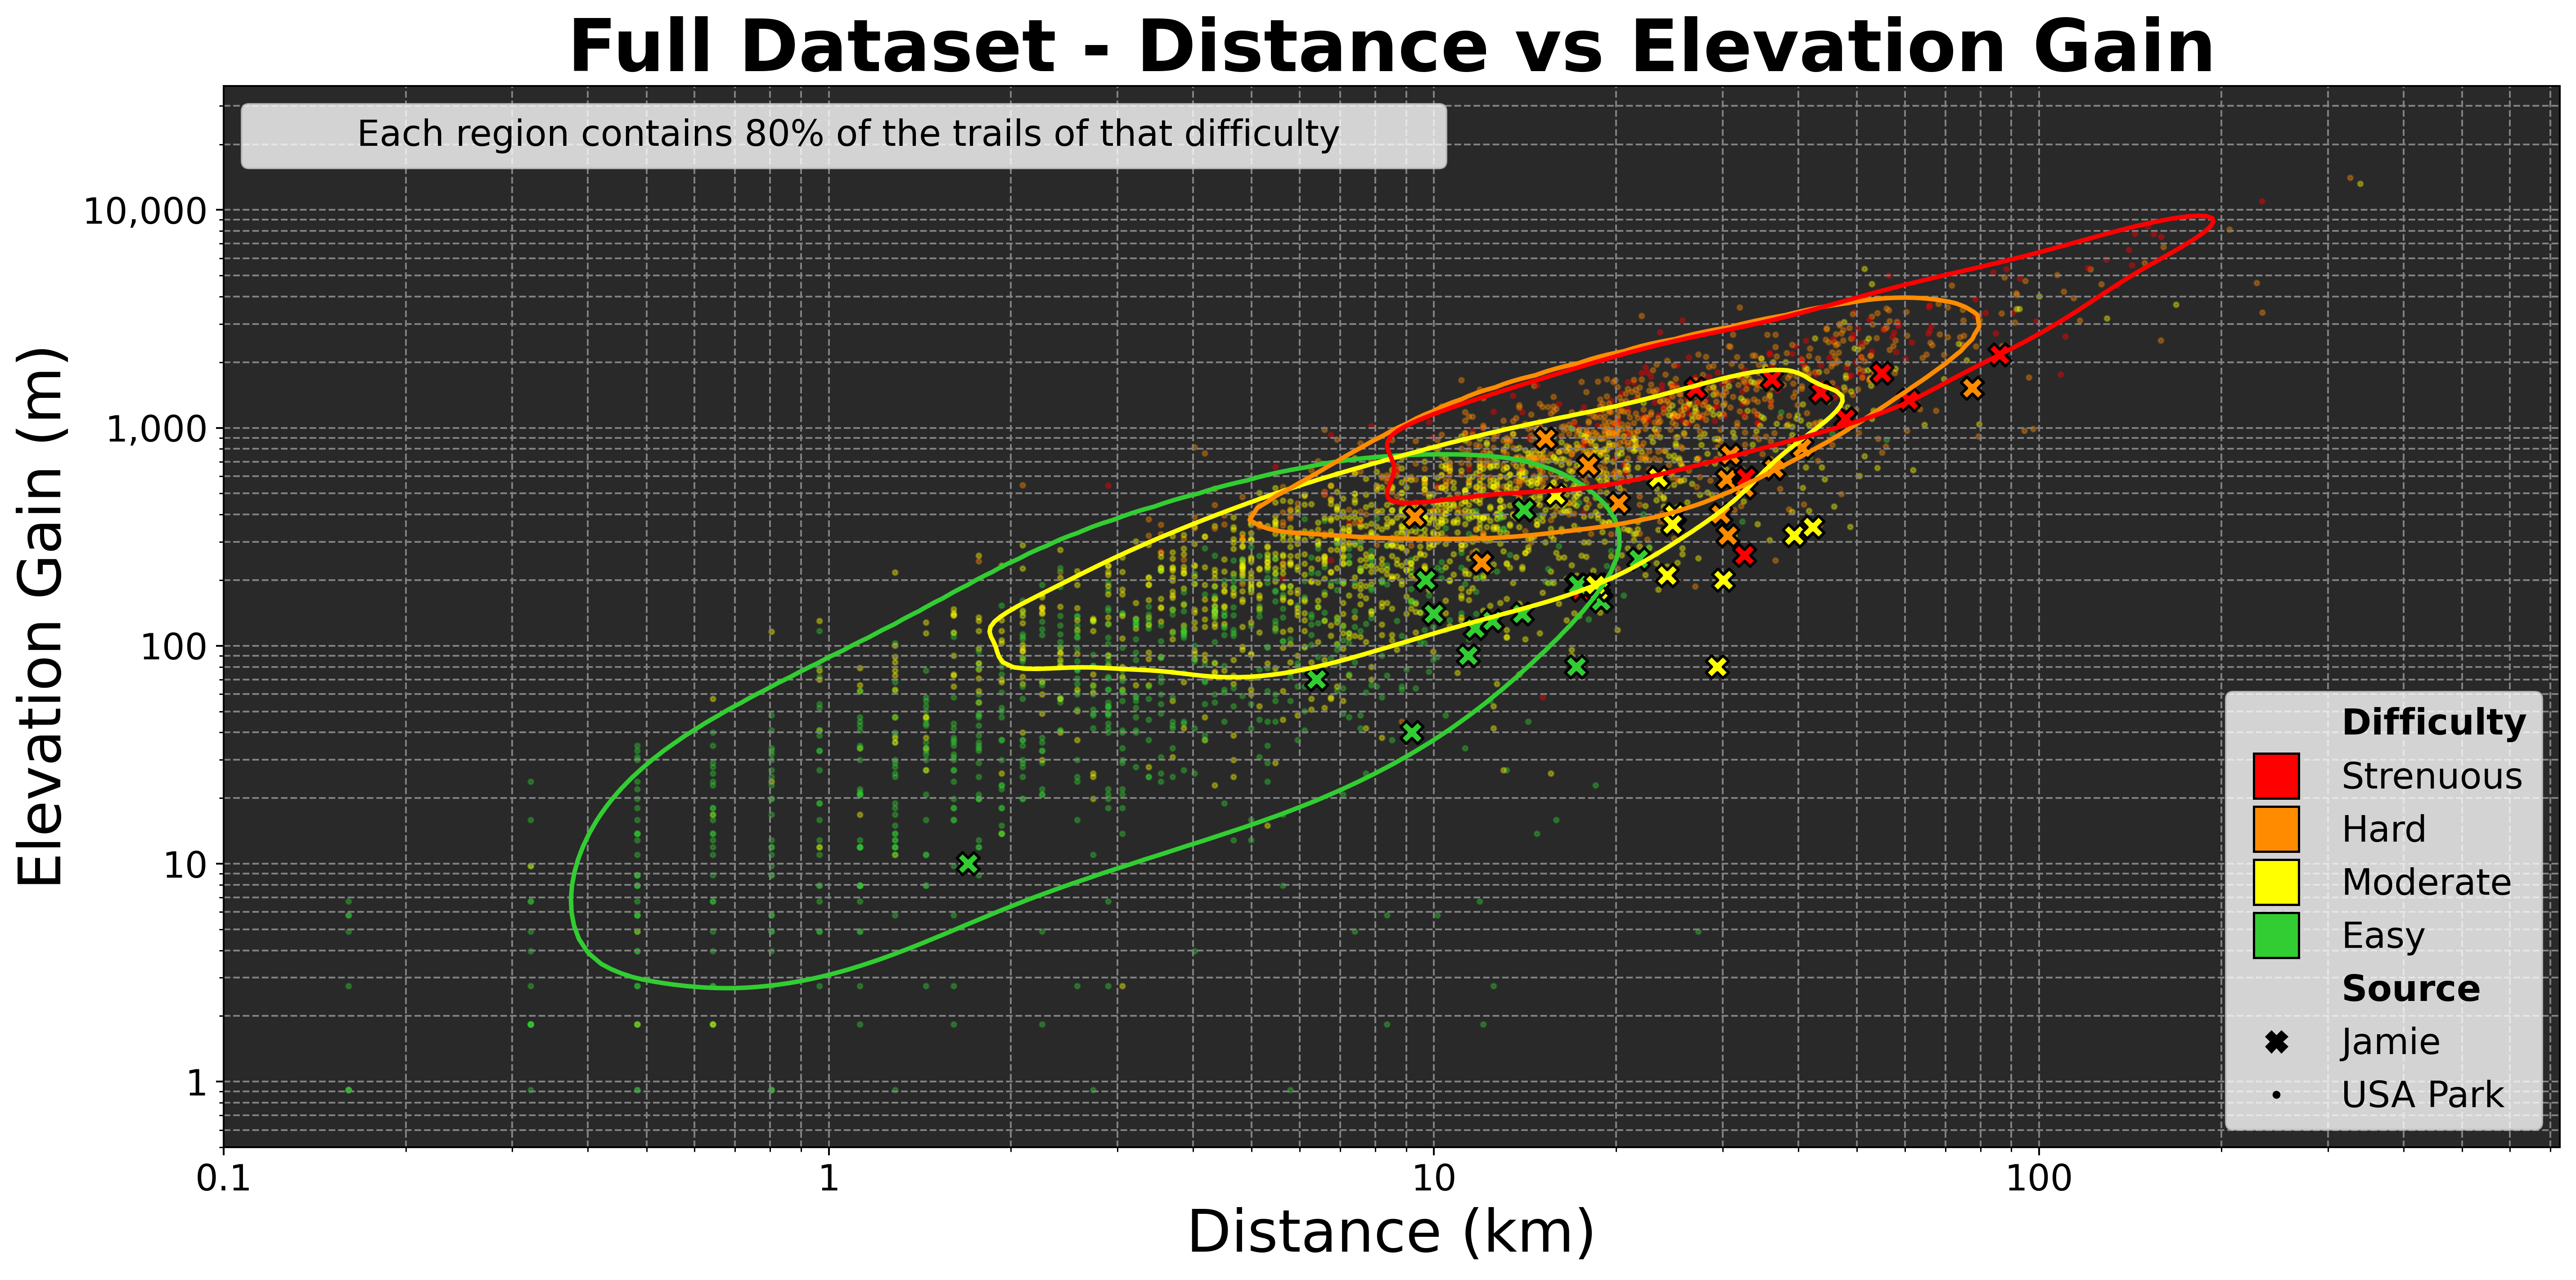

In [38]:
def difficultyColourIndex(trailDifficulty):
    return int((trailDifficulty - 1) / 2)

fig, ax = plt.subplots()

# Main scatter plot
shuffledUsaTrails = usaTrails.sample(frac=1)
shuffledUsaDists = shuffledUsaTrails.distance
shuffledUsaGains = shuffledUsaTrails.elevation_gain
shuffledUsaDifficultyColours = shuffledUsaTrails.apply(lambda trail: difficultyColourIndex(trail.difficulty), axis=1).copy()
plt.scatter(shuffledUsaDists, shuffledUsaGains, s=16, c=difficultyColors[shuffledUsaDifficultyColours], marker=".", alpha=0.33, zorder=1)

# Scatter plot of my personal hikes
myDists = myTrails.distance
myGains = myTrails.elevation_gain
myDifficultyColours = myTrails.apply(lambda trail: difficultyColourIndex(trail.difficulty), axis=1).copy()
plt.scatter(myDists,  myGains,  s=100, c=difficultyColors[myDifficultyColours], marker="X", edgecolors="k", lw=1.2, zorder=2)

# Defining Xs and Ys for difficulty categories
easyTrails = masterTrails.query("difficulty==1")
easyDists = easyTrails.distance
easyGains = easyTrails.elevation_gain + np.random.normal(0, 1e-6, len(easyTrails))

medTrails = masterTrails.query("difficulty==3")
medDists = medTrails.distance
medGains = medTrails.elevation_gain + + np.random.normal(0, 1e-6, len(medTrails))

hardTrails = masterTrails.query("difficulty==5")
hardDists = hardTrails.distance
hardGains = hardTrails.elevation_gain + np.random.normal(0, 1e-6, len(hardTrails))

vHardTrails = masterTrails.query("difficulty==7")
vHardDists = vHardTrails.distance
vHardGains = vHardTrails.elevation_gain + + np.random.normal(0, 1e-6, len(vHardTrails))

# Density countours
levels = 2
alphaLine = 1
thresh = 0.2
lineWidth = 2

sns.kdeplot(x=easyDists, y=easyGains, 
            cmap=ListedColormap(difficultyColors[0]), 
            log_scale=True, levels=levels, fill=False, alpha=alphaLine, thresh=thresh, linewidths=lineWidth, zorder=3)
sns.kdeplot(x=medDists, y=medGains, 
            cmap=ListedColormap(difficultyColors[1]), 
            log_scale=True, levels=levels, fill=False, alpha=alphaLine, thresh=thresh, linewidths=lineWidth, zorder=3)
sns.kdeplot(x=hardDists, y=hardGains, 
            cmap=ListedColormap(difficultyColors[2]), 
            log_scale=True, levels=levels, fill=False, alpha=alphaLine, thresh=thresh, linewidths=lineWidth, zorder=3)
sns.kdeplot(x=vHardDists, y=vHardGains, 
            cmap=ListedColormap(difficultyColors[3]), 
            log_scale=True, levels=levels, fill=False, alpha=alphaLine, thresh=thresh, linewidths=lineWidth, zorder=3)

# Main legend
legendElements1 = [Line2D([0], [0], marker="", c="none", label=r"$\bf{Difficulty}$"),
                   Line2D([0], [0], marker="s", color="none", markerfacecolor=difficultyColors[3], markersize=20, label="Strenuous"),
                   Line2D([0], [0], marker="s", color="none", markerfacecolor=difficultyColors[2], markersize=20, label="Hard"),
                   Line2D([0], [0], marker="s", color="none", markerfacecolor=difficultyColors[1], markersize=20, label="Moderate"),
                   Line2D([0], [0], marker="s", color="none", markerfacecolor=difficultyColors[0], markersize=20, label="Easy"),
                   Line2D([0], [0], marker="", c="none", label=r"$\bf{Source}$"),
                   Line2D([0], [0], marker="X", color="none", markerfacecolor="k", markersize=9, label=f"{masterUser}"),
                   Line2D([0], [0], marker=".", color="none", markerfacecolor="k", markersize=5, label="USA Park")]

legend1 = plt.legend(facecolor=legendColor, prop={"size": legendTextSize}, handles=legendElements1, loc=4)
plt.gca().add_artist(legend1)

# Info legend
legendElements2 = [Line2D([0], [0], marker="s", color="none", markerfacecolor="none", 
                         label=f"Each region contains {round((1-thresh)*100)}% of the trails of that difficulty        ")]
plt.legend(facecolor=legendColor, prop={"size": legendTextSize}, handles=legendElements2, loc=2)
   
# Plot settings
title = "Full Dataset - Distance vs Elevation Gain"
plt.title(title, size=titleSize, fontweight="bold")
plt.xlabel("Distance (km)", size=axisLabelSize)
plt.ylabel("Elevation Gain (m)", size=axisLabelSize)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(left=0.1)
ax.set_ylim(bottom=0.5)

ax.xaxis.set_major_locator(mticker.LogLocator(base=10.0, subs=None, numticks=10))
ax.yaxis.set_major_locator(mticker.LogLocator(base=10.0, subs=None, numticks=10))
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: "{:,.1f}".format(x) if x < 1 else "{:,.0f}".format(x)))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: "{:,.1f}".format(y) if y < 1 else "{:,.0f}".format(y)))
ax.set_xticks([0.1, 1, 10, 100])
ax.set_yticks([1, 10, 100, 1000, 10000])
ax.tick_params(axis="both", which="major", labelsize=tickLabelSize)
ax.grid(axis="both", which="both", linestyle="--", color="grey", zorder=0)

ax.set_facecolor(backgroundColor)
fig.patch.set_facecolor("w")

fig.set_dpi(DPI)
fig.set_size_inches(standardCanvasWidth, standardCanvasHeight)
plt.tight_layout()
plt.savefig(f"images/{title.replace(' ', '')}")
plt.show()

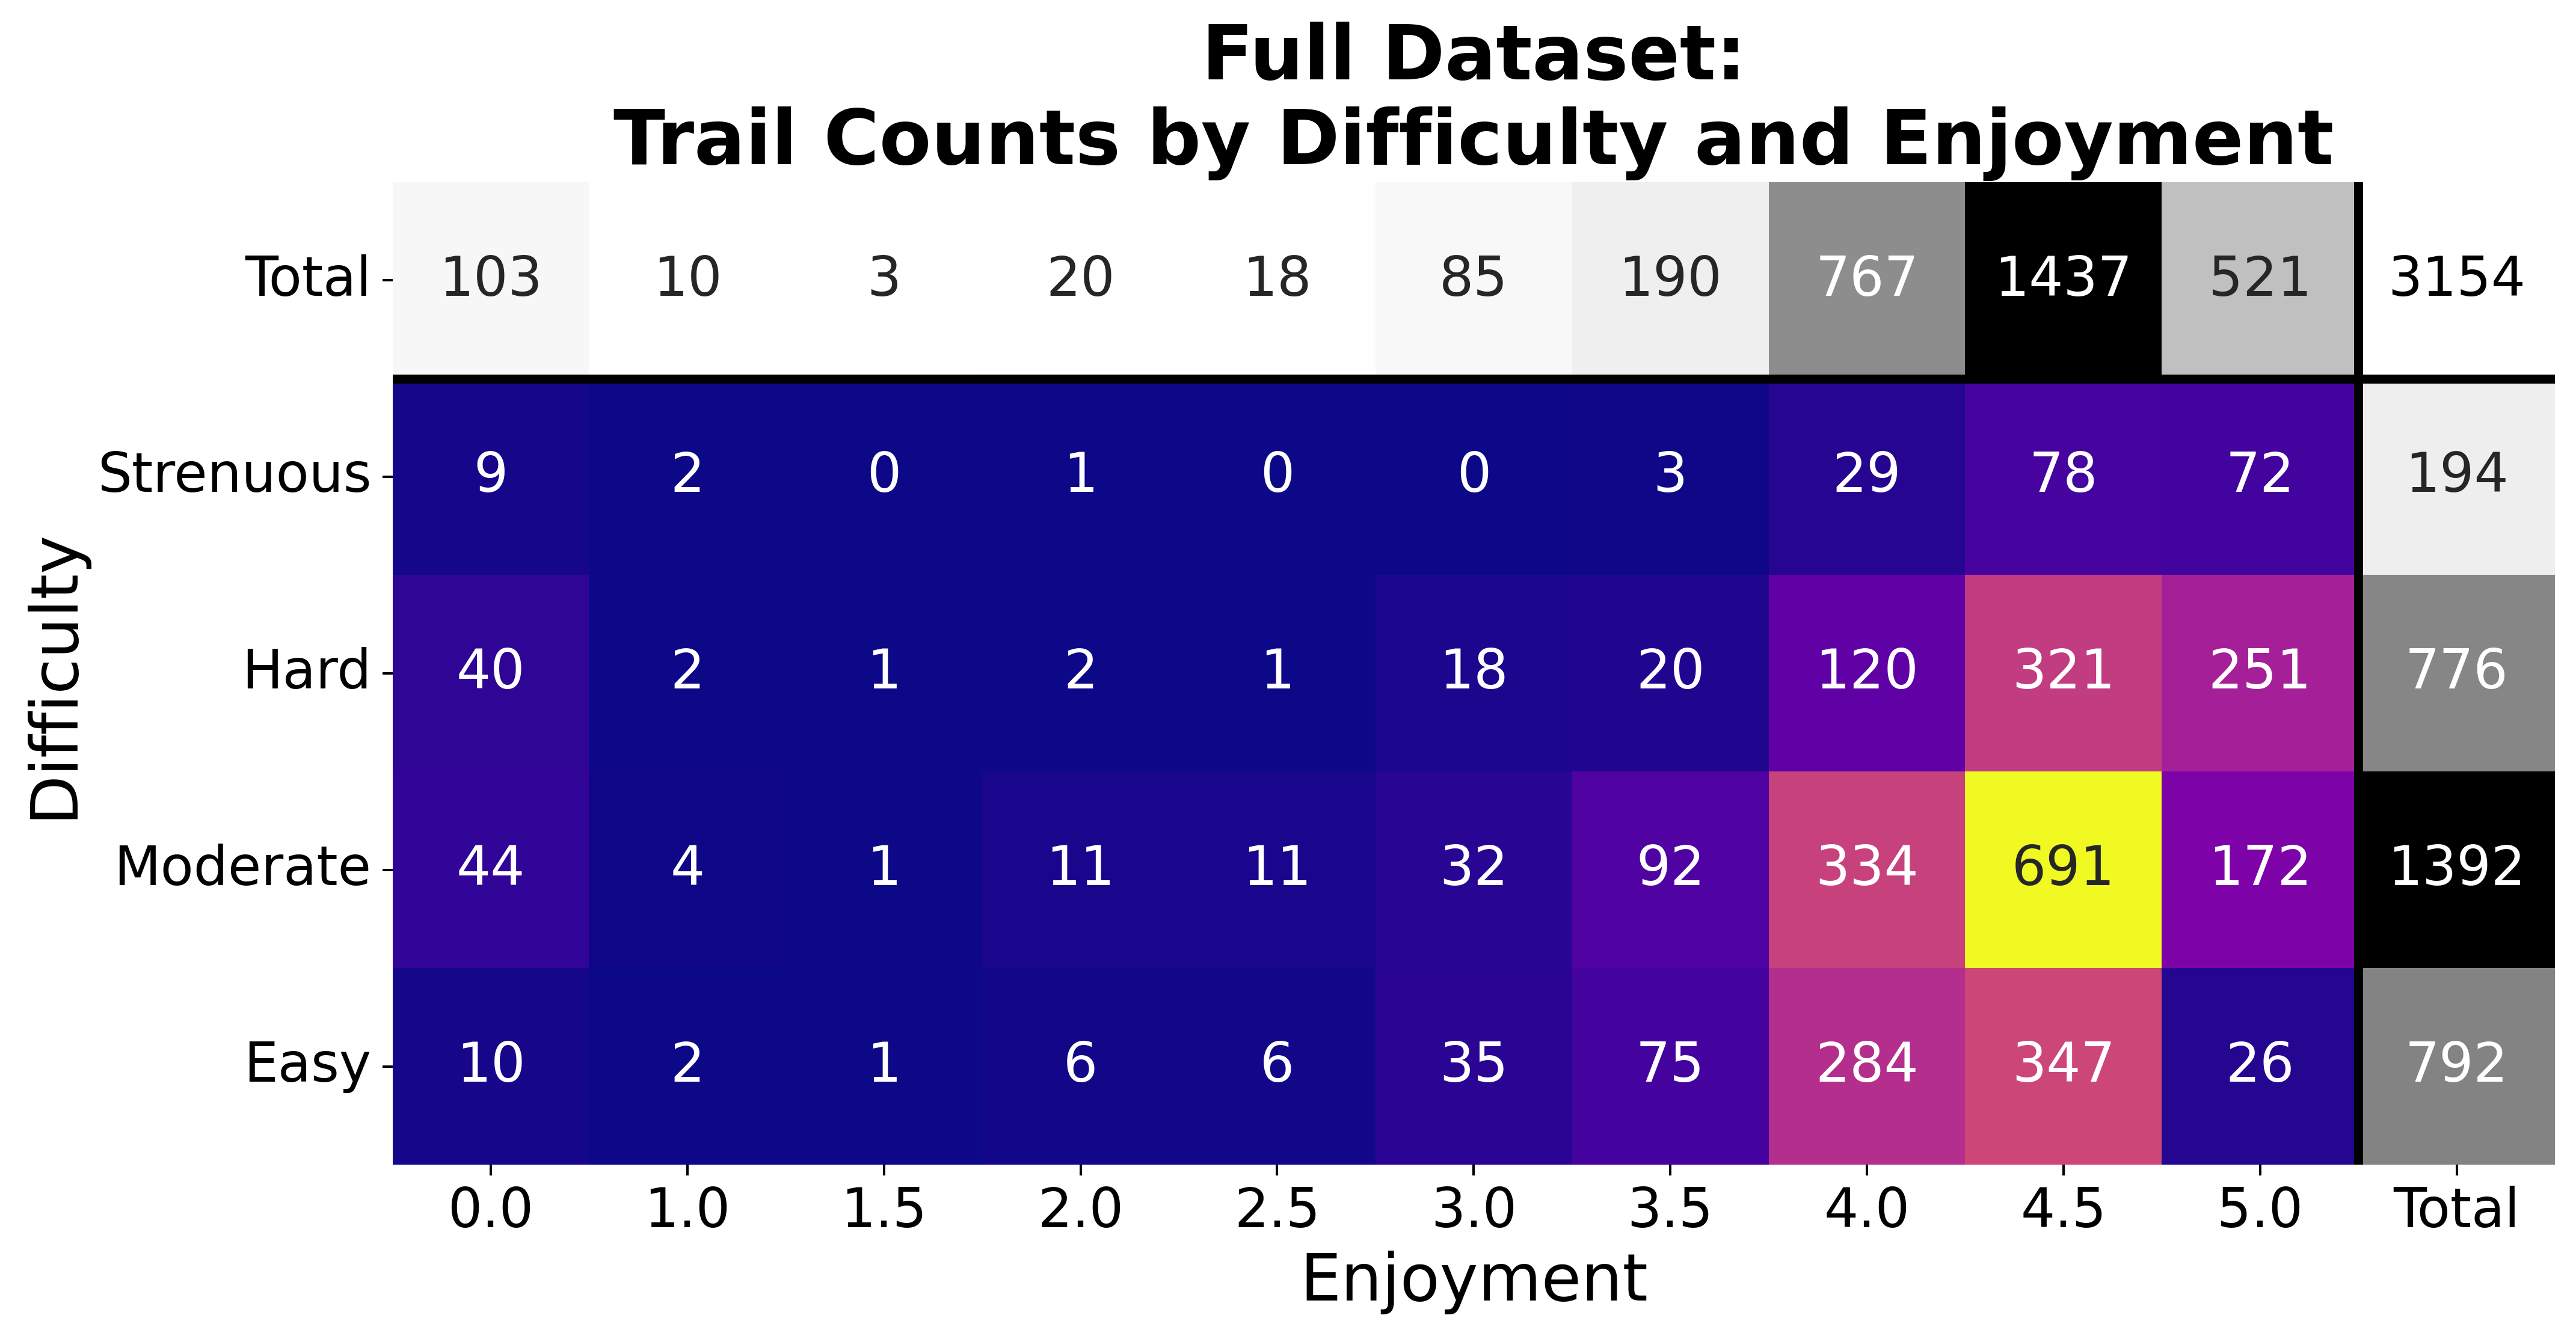

In [39]:
def heatPlotWithTotals(
    counts,
    plotTitle,
    xLabel=None,
    yLabel=None,
    xTickLabels=None,
    yTickLabels=None,
    savePlot=False
):

    counts = counts.copy()
    fontScale = 1.8

    # Add totals
    counts["Total"] = counts.sum(axis=1)
    totalRow = counts.sum(axis=0)
    totalRow.name = "Total"
    counts = pd.concat([counts, totalRow.to_frame().T])

    # Masks
    mainMask = np.ones_like(counts, dtype=bool)
    rowTotalMask = np.ones_like(counts, dtype=bool)
    colTotalMask = np.ones_like(counts, dtype=bool)

    mainMask[:-1, :-1] = False
    colTotalMask[:-1, -1] = False
    rowTotalMask[-1, :-1] = False

    mainMask[-1, -1] = True
    rowTotalMask[-1, -1] = True
    colTotalMask[-1, -1] = True

    # Plot
    fig, ax = plt.subplots(figsize=(12, 12))
    fig.set_dpi(DPI)
    fig.patch.set_facecolor("w")

    # Main heatmap
    sns.heatmap(
        counts,
        mask=mainMask,
        annot=True,
        fmt=".0f",
        cmap="plasma",
        square=True,
        cbar=False,
        vmin=0,
        annot_kws={"size": 10 * fontScale},
        ax=ax
    )

    # Total column
    sns.heatmap(
        counts,
        mask=colTotalMask,
        annot=True,
        fmt=".0f",
        cmap="Greys",
        square=True,
        cbar=False,
        vmin=0,
        annot_kws={"size": 10 * fontScale},
        ax=ax
    )

    # Total rows
    sns.heatmap(
        counts,
        mask=rowTotalMask,
        annot=True,
        fmt=".0f",
        cmap="Greys",
        square=True,
        cbar=False,
        vmin=0,
        annot_kws={"size": 10 * fontScale},
        ax=ax
    )

    # Grand total
    ax.add_patch(
        plt.Rectangle(
            (counts.shape[1] - 1, counts.shape[0] - 1),
            1, 1,
            facecolor="white",
            edgecolor="white",
            linewidth=2,
            zorder=5
        )
    )

    ax.text(
        counts.shape[1] - 0.5,
        counts.shape[0] - 0.5,
        int(counts.iloc[-1, -1]),
        ha="center",
        va="center",
        color="black",
        fontsize=10 * fontScale,
        zorder=6
    )

    # Dividing lines
    ax.axhline(len(counts) - 1, color="black", linewidth=3, zorder=7)
    ax.axvline(len(counts.columns) - 1, color="black", linewidth=3, zorder=7)

    ax.set_xlabel(xLabel or "", fontsize=12 * fontScale)
    ax.set_ylabel(yLabel or "", fontsize=12 * fontScale)
    ax.set_title(plotTitle, fontweight="bold", fontsize=14 * fontScale)

    ax.invert_yaxis()
    ax.tick_params(axis="both", labelsize=10 * fontScale)

    if xTickLabels is not None:
        ax.set_xticks(np.arange(len(counts.columns)) + 0.5)
        ax.set_xticklabels(xTickLabels + ["Total"], rotation=0)

    if yTickLabels is not None:
        ax.set_yticks(np.arange(len(counts.index)) + 0.5)
        ax.set_yticklabels(yTickLabels + ["Total"], rotation=0)

    plt.tight_layout()

    if savePlot:
        plt.savefig(f"images/{plotTitle.replace(' ', '')}", bbox_inches="tight")

    plt.show()


trailCounts = masterTrails.groupby(["difficulty", "enjoyment"]).size().unstack(fill_value=0)

heatPlotWithTotals(trailCounts, 
                   "Full Dataset:\nTrail Counts by Difficulty and Enjoyment", 
                   "Enjoyment", 
                   "Difficulty",
                   yTickLabels = ["Easy", "Moderate", "Hard", "Strenuous"], 
                   savePlot = True)

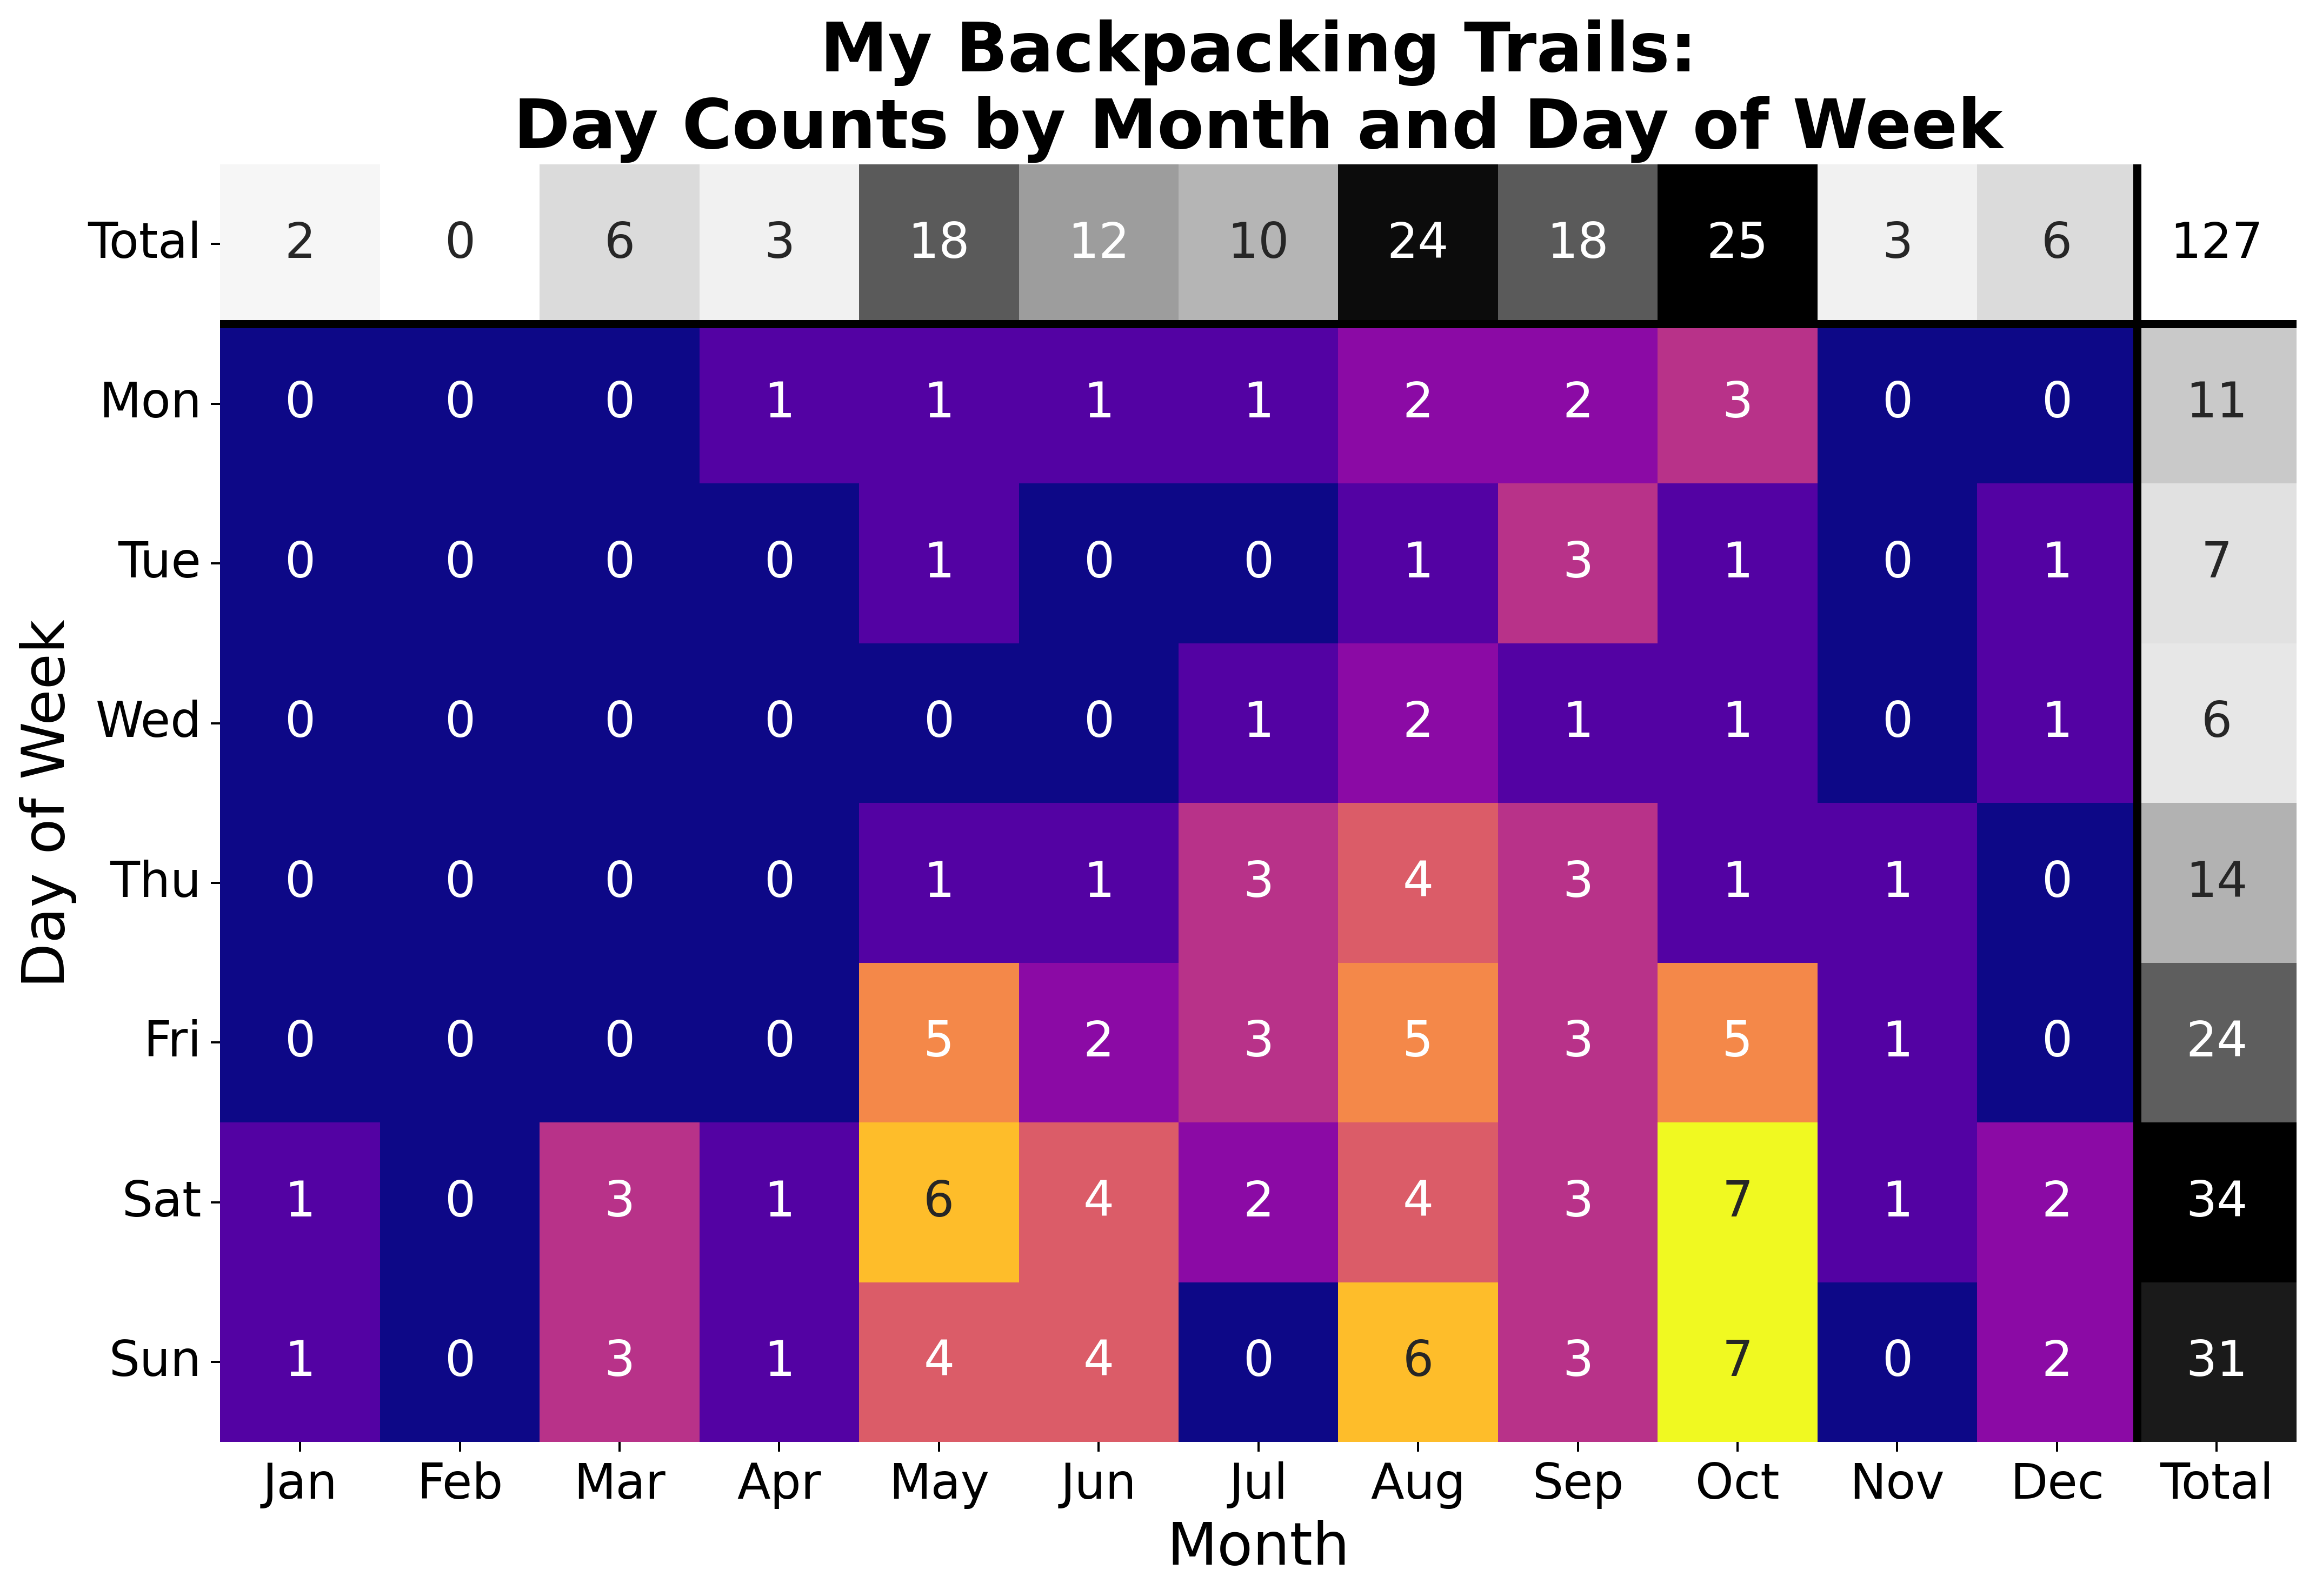

In [40]:
dayCounts = pd.DataFrame(
    0,
    index=range(7),
    columns=range(1, 13)
)

for _, row in myTrails.iterrows():
    dateRange = pd.date_range(row["start_date"], row["end_date"], freq="D")
    for d in dateRange:
        dayCounts.loc[d.weekday(), d.month] += 1

dayLabels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"][::-1]
monthLabels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

heatPlotWithTotals(dayCounts.iloc[::-1], 
                   "My Backpacking Trails:\nDay Counts by Month and Day of Week", 
                   "Month",
                   "Day of Week",
                   xTickLabels = monthLabels,
                   yTickLabels = dayLabels,
                   savePlot = True)

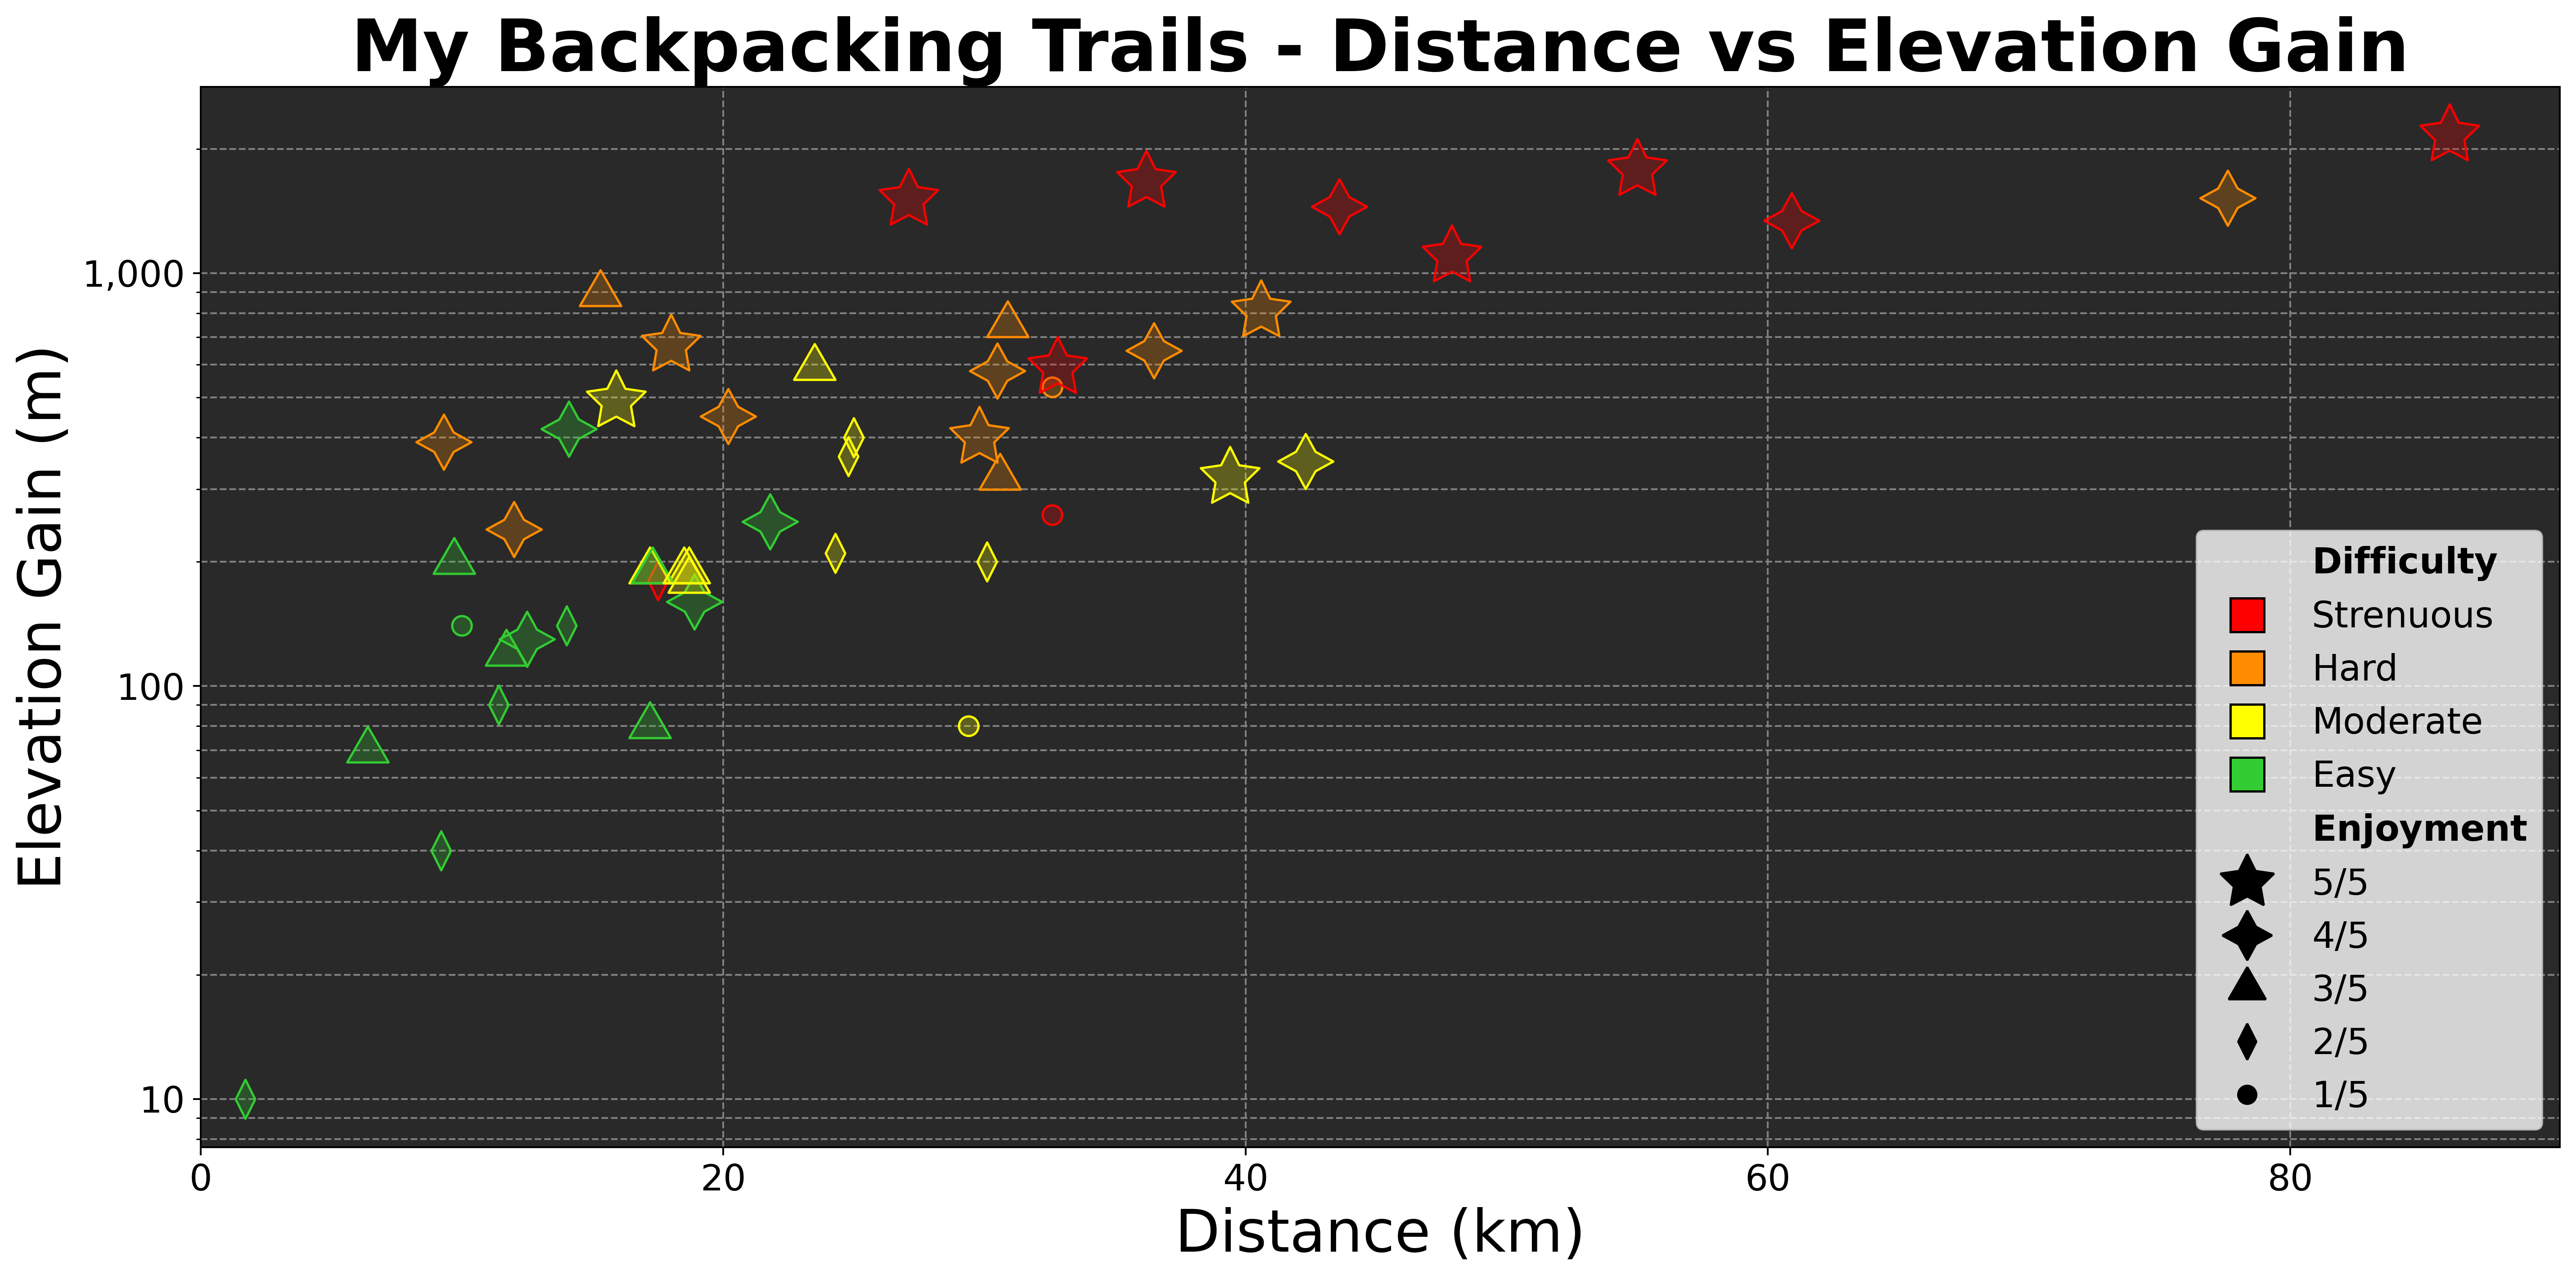

In [74]:
def distGainEnjoyDiffPlot(title,
                          xLabel,
                          ylabel,
                          dists,
                          gains,
                          difficulties,
                          enjoyments,
                          savePlot=False):

    fig, ax = plt.subplots()
    ax.set_title(title, size=titleSize, fontweight="bold")

    # Prepare difficulty mapping inside function
    diffIndices = [difficultyColourIndex(d) for d in difficulties]
    mappedColors = [difficultyColors[i] for i in diffIndices]

    markers = ["o", (2, 1, 0), (3, 1, 0), (4, 1, 0), (5, 1, 0)]
    markerSizes = [75, 300, 450, 600, 750]

    legendElements = [
        Line2D([0], [0], marker="", c="none", label=r"$\bf{Difficulty}$"),
        Line2D([0], [0], marker="s", c="none", label="Strenuous", markerfacecolor=difficultyColors[3], markersize=15),
        Line2D([0], [0], marker="s", c="none", label="Hard", markerfacecolor=difficultyColors[2], markersize=15),
        Line2D([0], [0], marker="s", c="none", label="Moderate", markerfacecolor=difficultyColors[1], markersize=15),
        Line2D([0], [0], marker="s", c="none", label="Easy", markerfacecolor=difficultyColors[0], markersize=15),
        Line2D([0], [0], marker="", c="none", label=r"$\bf{Enjoyment}$"),
        Line2D([0], [0], marker=markers[4], c="none", label="5/5", markerfacecolor="k", markersize=25),
        Line2D([0], [0], marker=markers[3], c="none", label="4/5", markerfacecolor="k", markersize=22),
        Line2D([0], [0], marker=markers[2], c="none", label="3/5", markerfacecolor="k", markersize=19),
        Line2D([0], [0], marker=markers[1], c="none", label="2/5", markerfacecolor="k", markersize=16),
        Line2D([0], [0], marker=markers[0], c="none", label="1/5", markerfacecolor="k", markersize=8),
    ]

    ax.legend(handles=legendElements, facecolor=legendColor, prop={"size": legendTextSize}, loc=4)

    # Loop through data to plot individual markers
    for dist, gain, enjoy, diffColor in zip(dists, gains, enjoyments, mappedColors):
        # Round and clip index to 0-4 range
        ratingIndex = int(np.clip(round(enjoy) - 1, 0, 4))
        
        ax.scatter(
            dist,
            gain,
            facecolors=[mcolors.to_rgba(diffColor, alpha=0.25)],
            edgecolors=[mcolors.to_rgba(diffColor, alpha=1)],
            marker=markers[ratingIndex],
            s=markerSizes[ratingIndex],
            zorder=2,
            linewidths=1,
        )

    fig.set_size_inches(standardCanvasWidth, standardCanvasHeight)
    plt.rcParams["axes.facecolor"] = backgroundColor
    fig.set_dpi(DPI)

    ax.set_yscale("log")
    ax.set_xlabel(xLabel, size=axisLabelSize)
    ax.set_ylabel(ylabel, size=axisLabelSize)
    ax.set_xlim(left=0)
    
    ax.grid(axis="both", which="both", ls="--", c="grey", zorder=0)
    ax.tick_params(axis="both", which="both", labelsize=tickLabelSize)
    
    # Format log scale ticks
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: "{:,.1f}".format(y) if y < 1 else "{:,.0f}".format(y)))

    fig.patch.set_facecolor("w")
    plt.tight_layout()

    if savePlot:
        plt.savefig(f"images/{title.replace(' ', '')}")

    plt.show()

distGainEnjoyDiffPlot(
    "My Backpacking Trails - Distance vs Elevation Gain",
    "Distance (km)",
    "Elevation Gain (m)",
    myTrails.distance,
    myTrails.elevation_gain,
    myTrails.difficulty,
    myTrails.enjoyment,
    savePlot=True
)

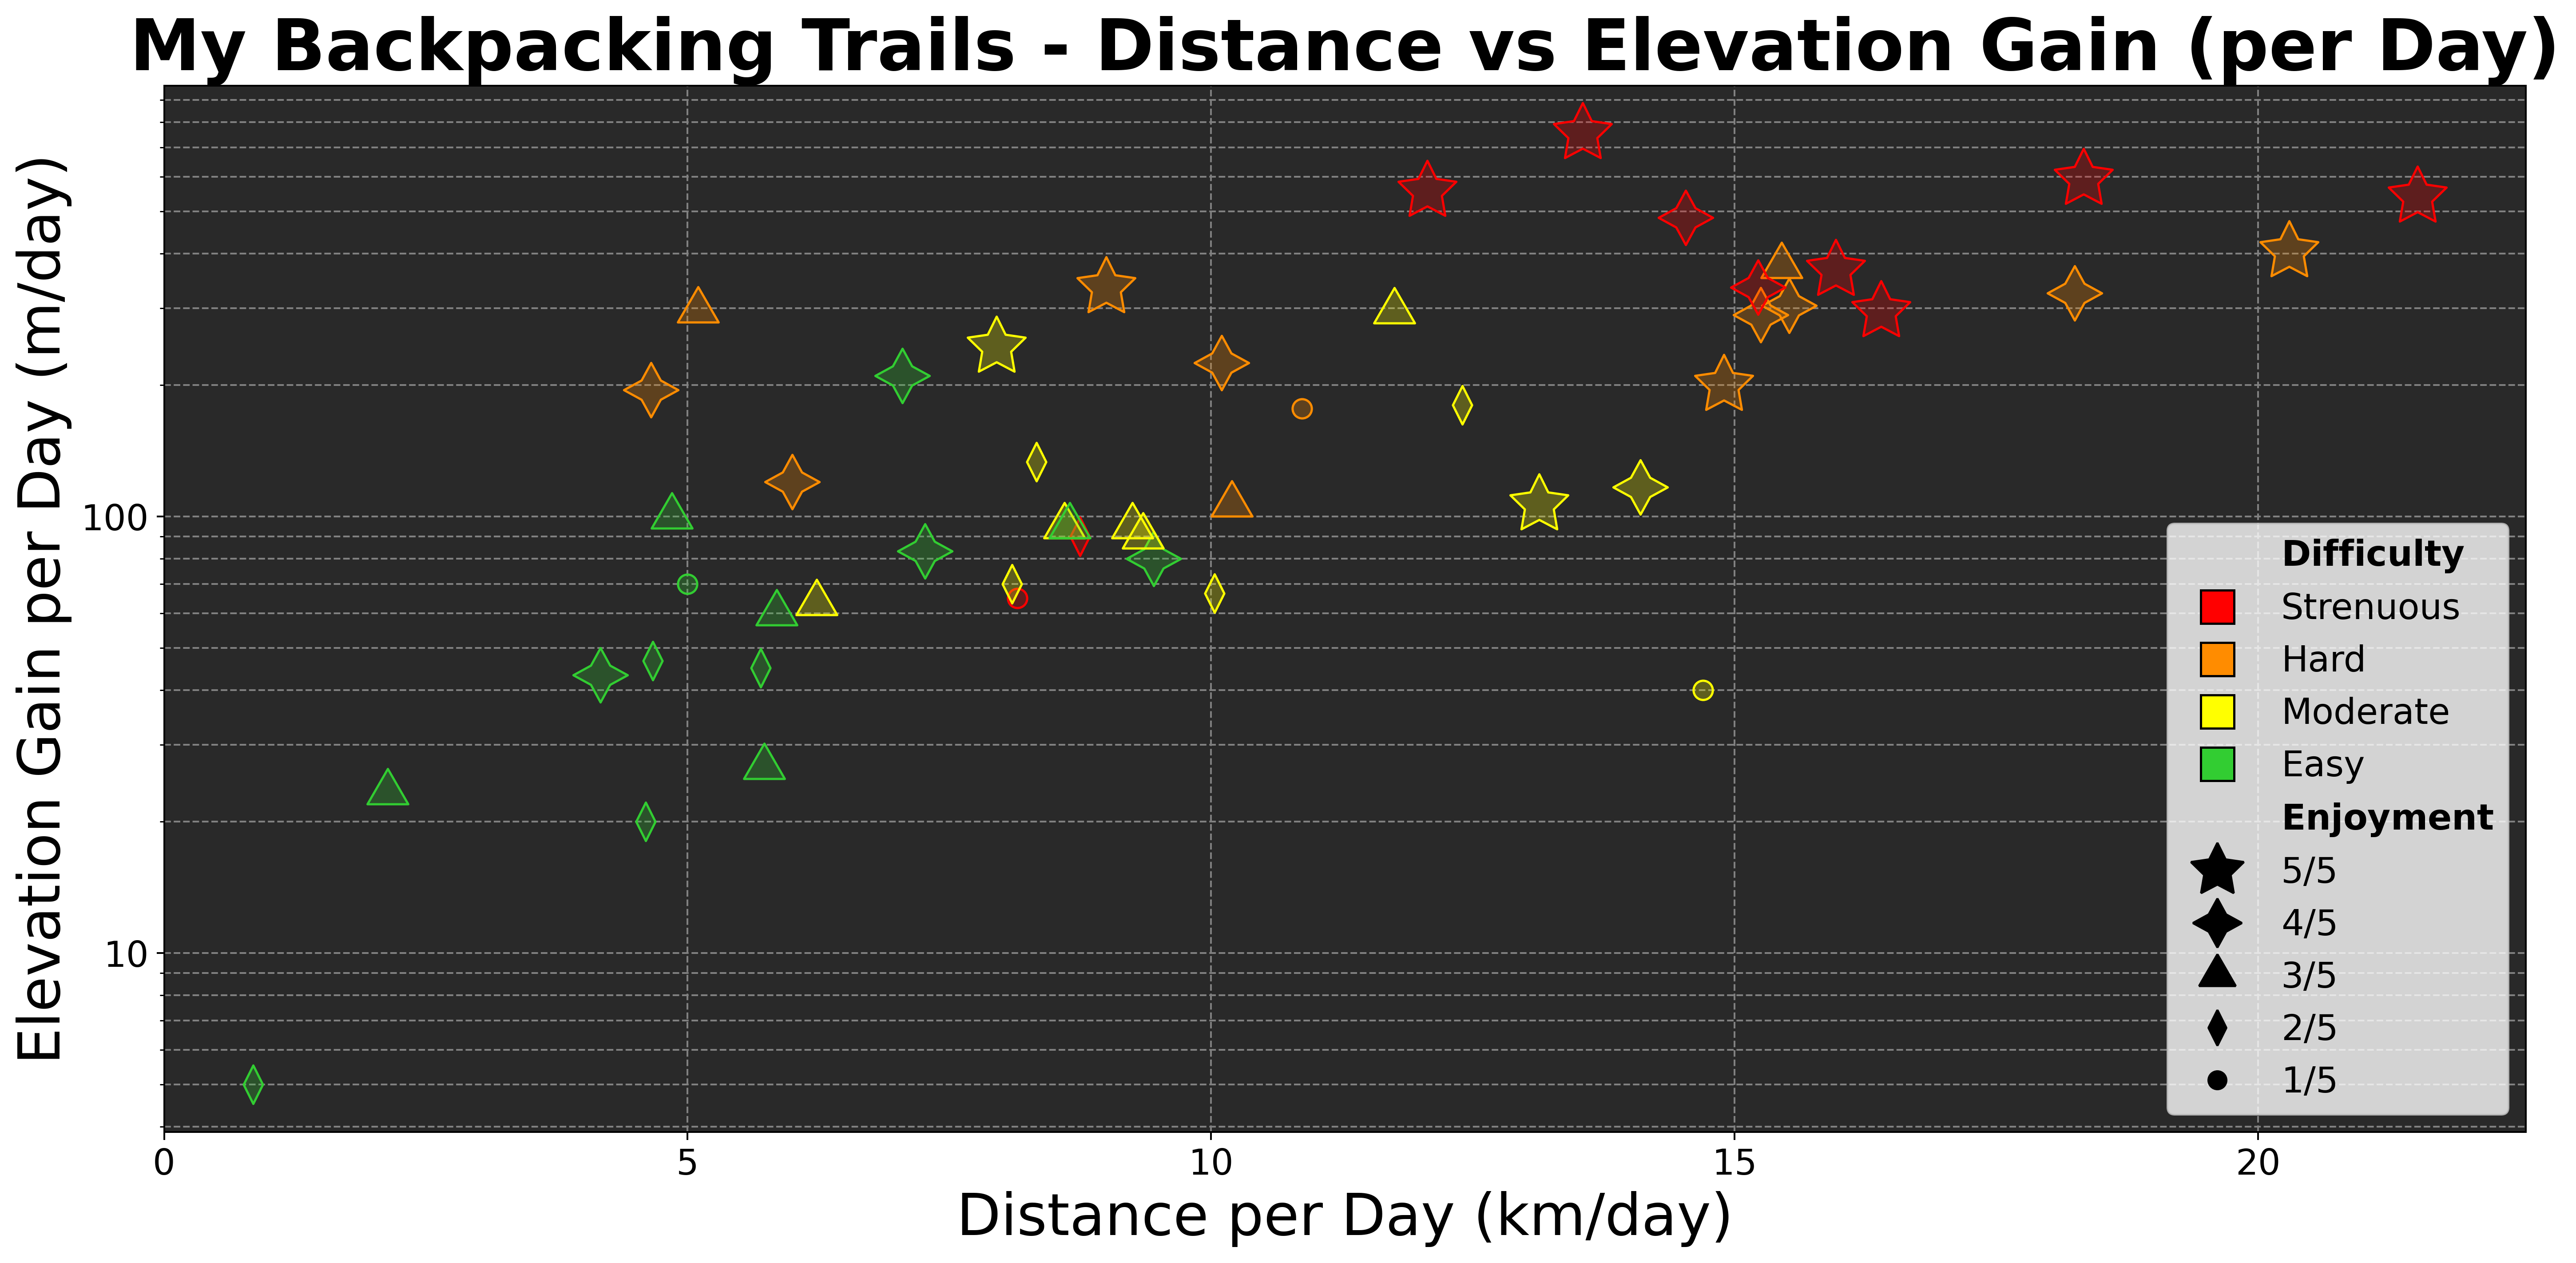

In [42]:
myDistsPerDay = myTrails.distance.divide(myTrails.days)
myGainsPerDay = myTrails.elevation_gain.divide(myTrails.days)

distGainEnjoyDiffPlot(
    "My Backpacking Trails - Distance vs Elevation Gain (per Day)",
    "Distance per Day (km/day)",
    "Elevation Gain per Day (m/day)",
    myDistsPerDay, 
    myGainsPerDay, 
    myTrails.difficulty,
    myTrails.enjoyment,
    savePlot=True
)

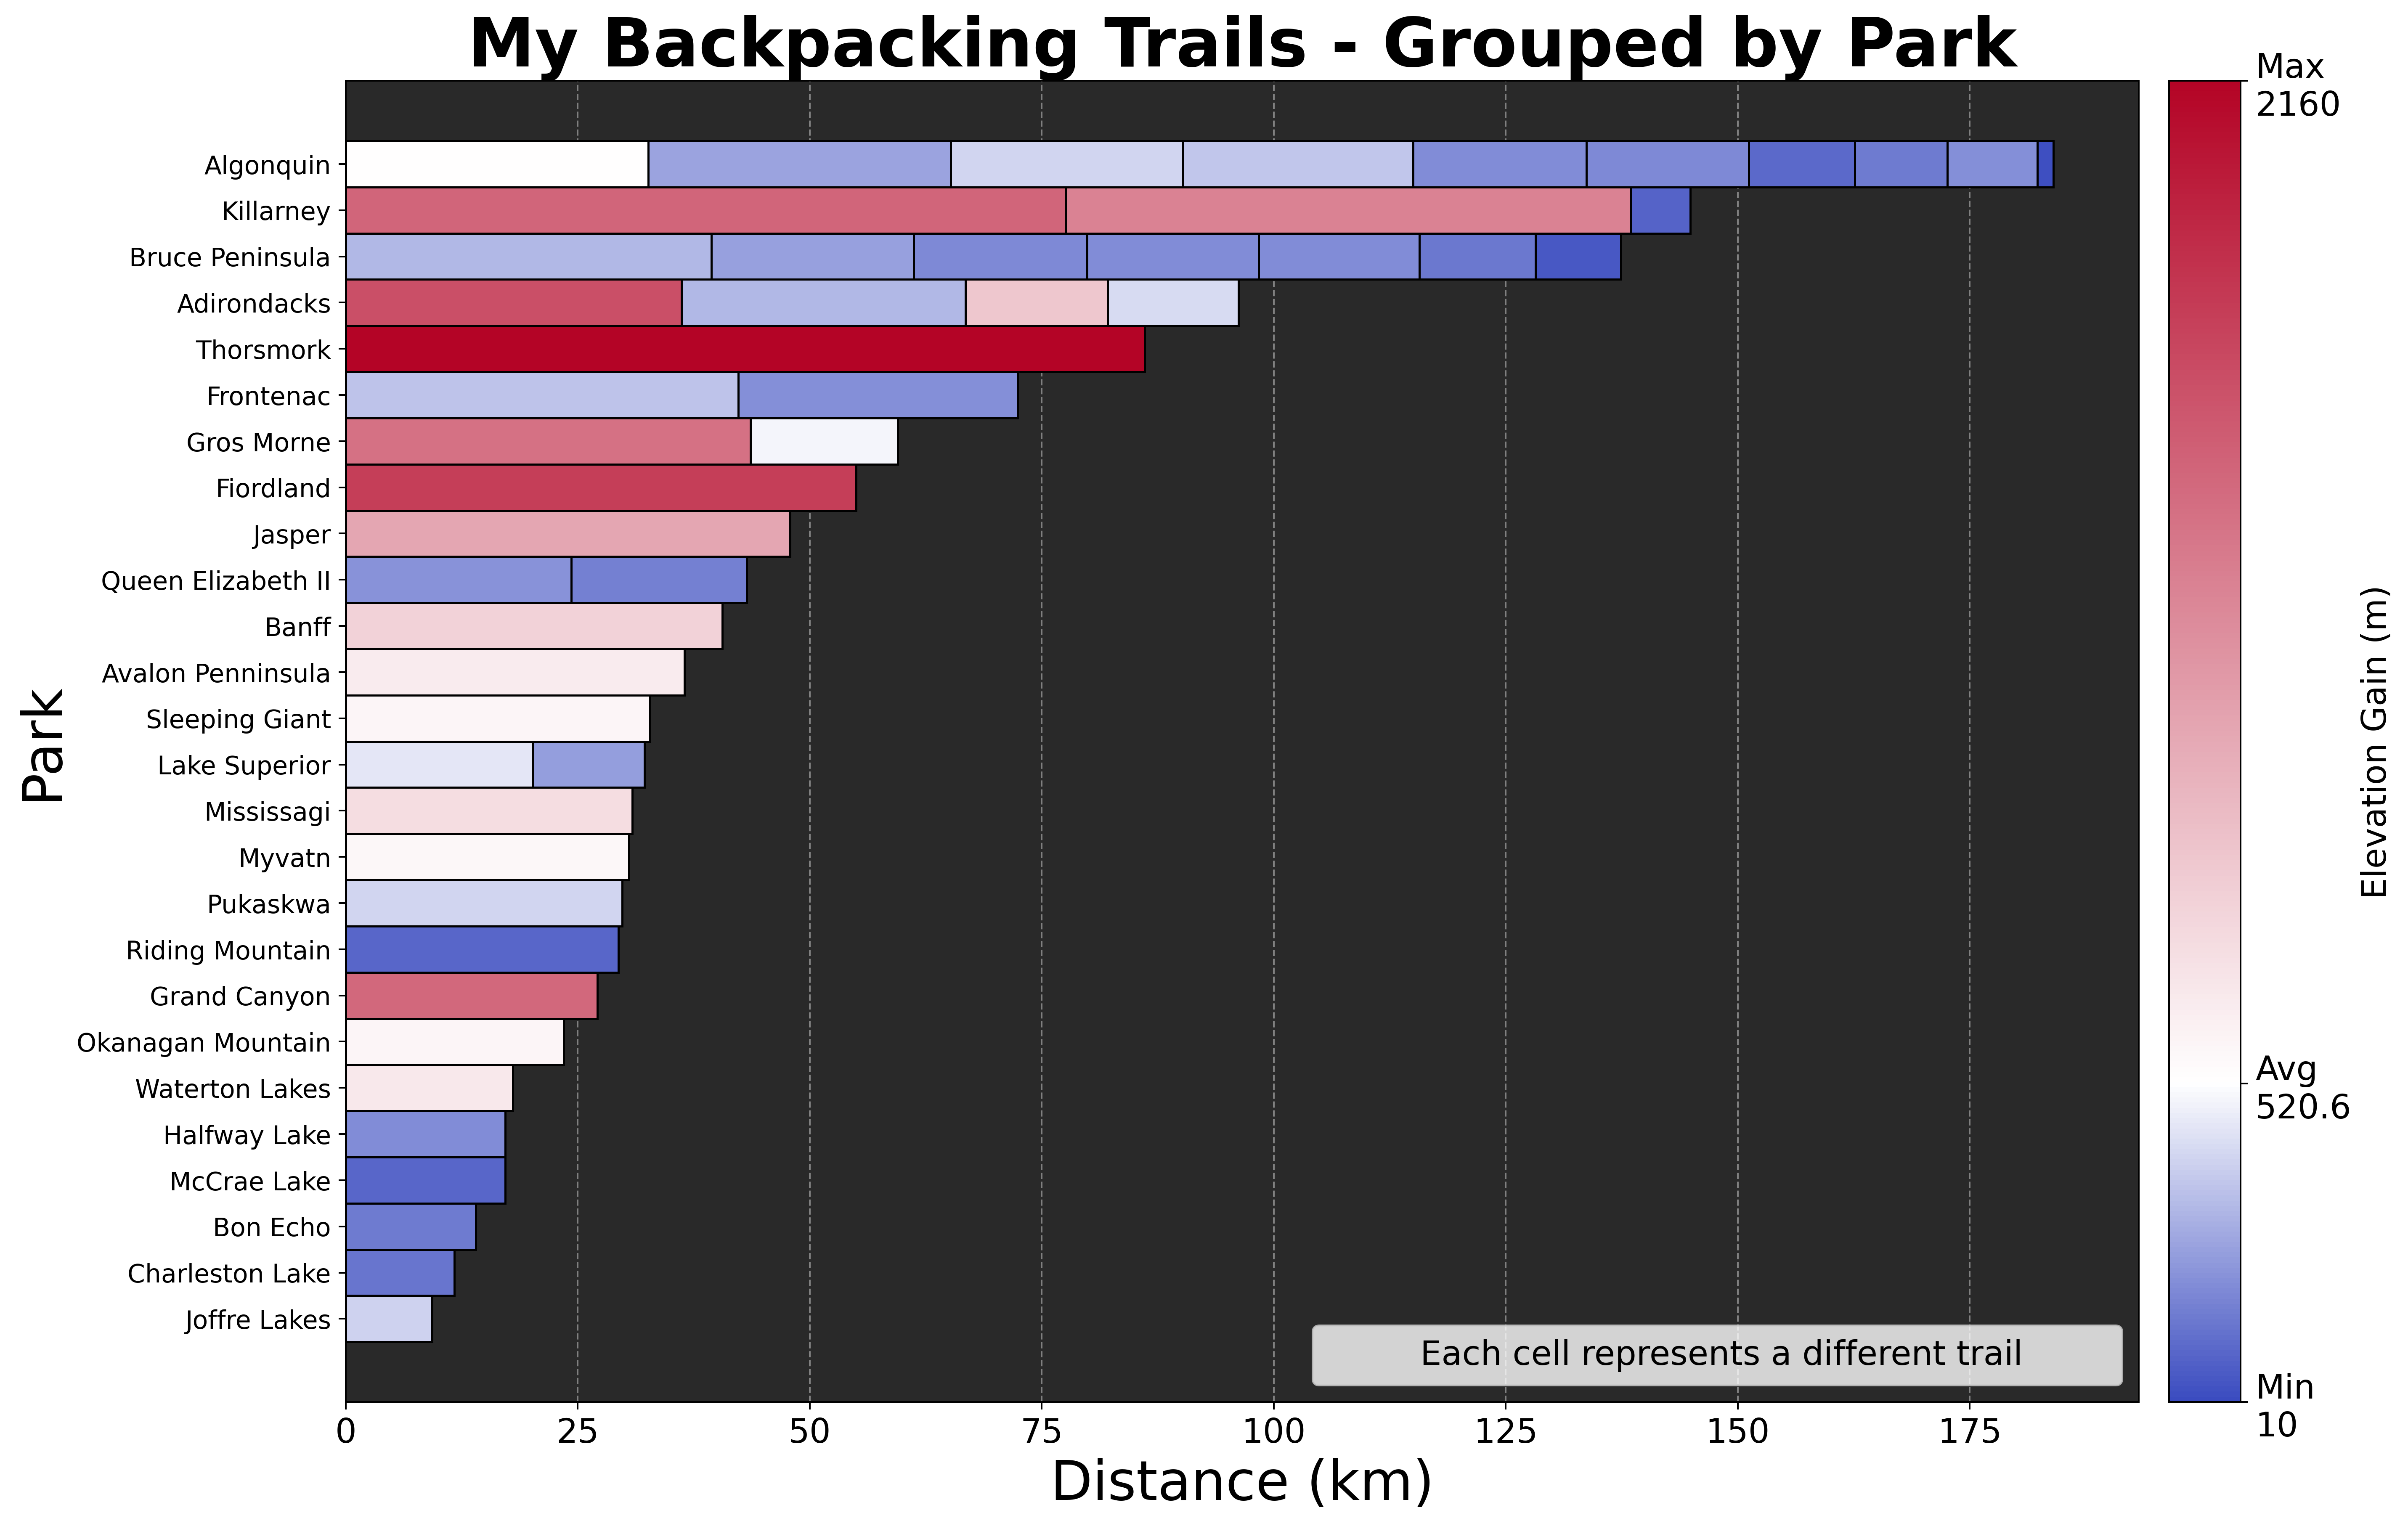

In [43]:
def addTrailToBarStack(trail, barFeature, colorFeature, groups, groupBy, barValues, barColors):
    idx = groups.tolist().index(trail[groupBy])
    barStack = barValues[:, idx]
    for j, val in enumerate(barStack):
        if val == 0:
            barValues[j, idx] = trail[barFeature]
            barColors[j, idx] = trail[colorFeature]
            break

def stackedBarPlot(label, 
                   xLabel,
                   trails,
                   barFeature,
                   colorFeature=None,
                   colorLabel="",
                   groupBy="park",
                   barThickness=0.33,
                   savePlot=False):

    if colorFeature is None:
        colorFeature = barFeature

    # Determine groups and stack size
    groups = (
        trails[[groupBy, barFeature]]
        .groupby(groupBy)
        .sum()
        .sort_values(barFeature, ascending=True)
        .reset_index()[groupBy]
    )
    numBarsStacked = trails[groupBy].value_counts().iloc[0]
    barValues = np.zeros((numBarsStacked, len(groups)))
    barColors = np.zeros((numBarsStacked, len(groups)))

    sortedTrails = trails[[groupBy, barFeature, colorFeature]].sort_values(
        [groupBy, barFeature], ascending=[True, False]
    )
    sortedTrails.apply(
        lambda trail: addTrailToBarStack(trail, barFeature, colorFeature, groups, groupBy, barValues, barColors),
        axis=1
    )

    # Create color map
    cMax = sortedTrails[colorFeature].max()
    cMin = sortedTrails[colorFeature].min()
    cAvg = sortedTrails[colorFeature].mean()
    colorRange = np.array(["#3B4CC0", "w", "#B40426"]) # Modified coolwarm, white is at average, not middle
    colorList = [(0.0, colorRange[0]), (cAvg / cMax, colorRange[1]), (1.0, colorRange[2])]
    cmap = mcolors.LinearSegmentedColormap.from_list("", colorList)
    barColors /= cMax  # Normalize

    # Plotting
    fig, ax = plt.subplots()
    fig.set_dpi(DPI)
    fig.patch.set_facecolor("w")
    plt.rcParams["axes.facecolor"] = backgroundColor

    for i in range(barValues.shape[0]):
        ax.barh(
            groups,
            barValues[i],
            left=np.sum(barValues[:i], axis=0),
            color=cmap(barColors[i]),
            edgecolor="k",
            height=1,
            zorder=2,
        )
    
    # Figure height scales with number of groups
    fig.set_size_inches(standardCanvasWidth, 1.6 + len(groups)*barThickness)

    # Legend
    legendElements = [Line2D([0], [0], marker="s", c="none", label="Each cell represents a different trail        ")]
    ax.legend(handles=legendElements, facecolor=legendColor, prop={"size": legendTextSize})

    # Axes formatting
    ax.yaxis.set_major_locator(mticker.FixedLocator(range(len(groups))))
    ax.set_yticklabels(groups)
    ax.tick_params(axis="x", which="both", labelsize=tickLabelSize)
    ax.tick_params(axis="y", which="both", labelsize=12)
    plotTitle = f"{label} - Grouped by {groupBy.capitalize()}"
    ax.set_title(plotTitle, size=titleSize, fontweight="bold")
    
    plt.grid(axis="x", which="both", ls="--", c="grey", zorder=0)
    plt.grid(axis="y", which="both", ls="none")
    plt.xlabel(xLabel, size=axisLabelSize)
    plt.ylabel(groupBy.capitalize(), size=axisLabelSize)
    fig.set_size_inches(standardCanvasWidth, 1.6 + len(groups) * barThickness)

    # Colorbar
    sm = cm.ScalarMappable(cmap=cmap)
    tick_locs = np.asarray([loc for loc, _ in colorList], dtype=float)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="4%", pad=0.2)
    cbar = plt.colorbar(sm, orientation="vertical", ticks=tick_locs, cax=cax)
    cbar.set_label(colorLabel, size=tickLabelSize)
    cbar.ax.tick_params(labelsize=tickLabelSize)
    cbar.set_ticklabels([f"Min\n{round(cMin,1)}", f"Avg\n{round(cAvg,1)}", f"Max\n{round(cMax,1)}"])

    plt.tight_layout()
    if savePlot:
        plt.savefig(f"images/{plotTitle.replace(' ','')}", bbox_inches="tight")
    plt.show()

stackedBarPlot(
    label="My Backpacking Trails",
    xLabel="Distance (km)",
    trails=myTrails,
    barFeature="distance",
    colorFeature="elevation_gain",
    colorLabel="Elevation Gain (m)",
    groupBy="park",
    savePlot=True
)

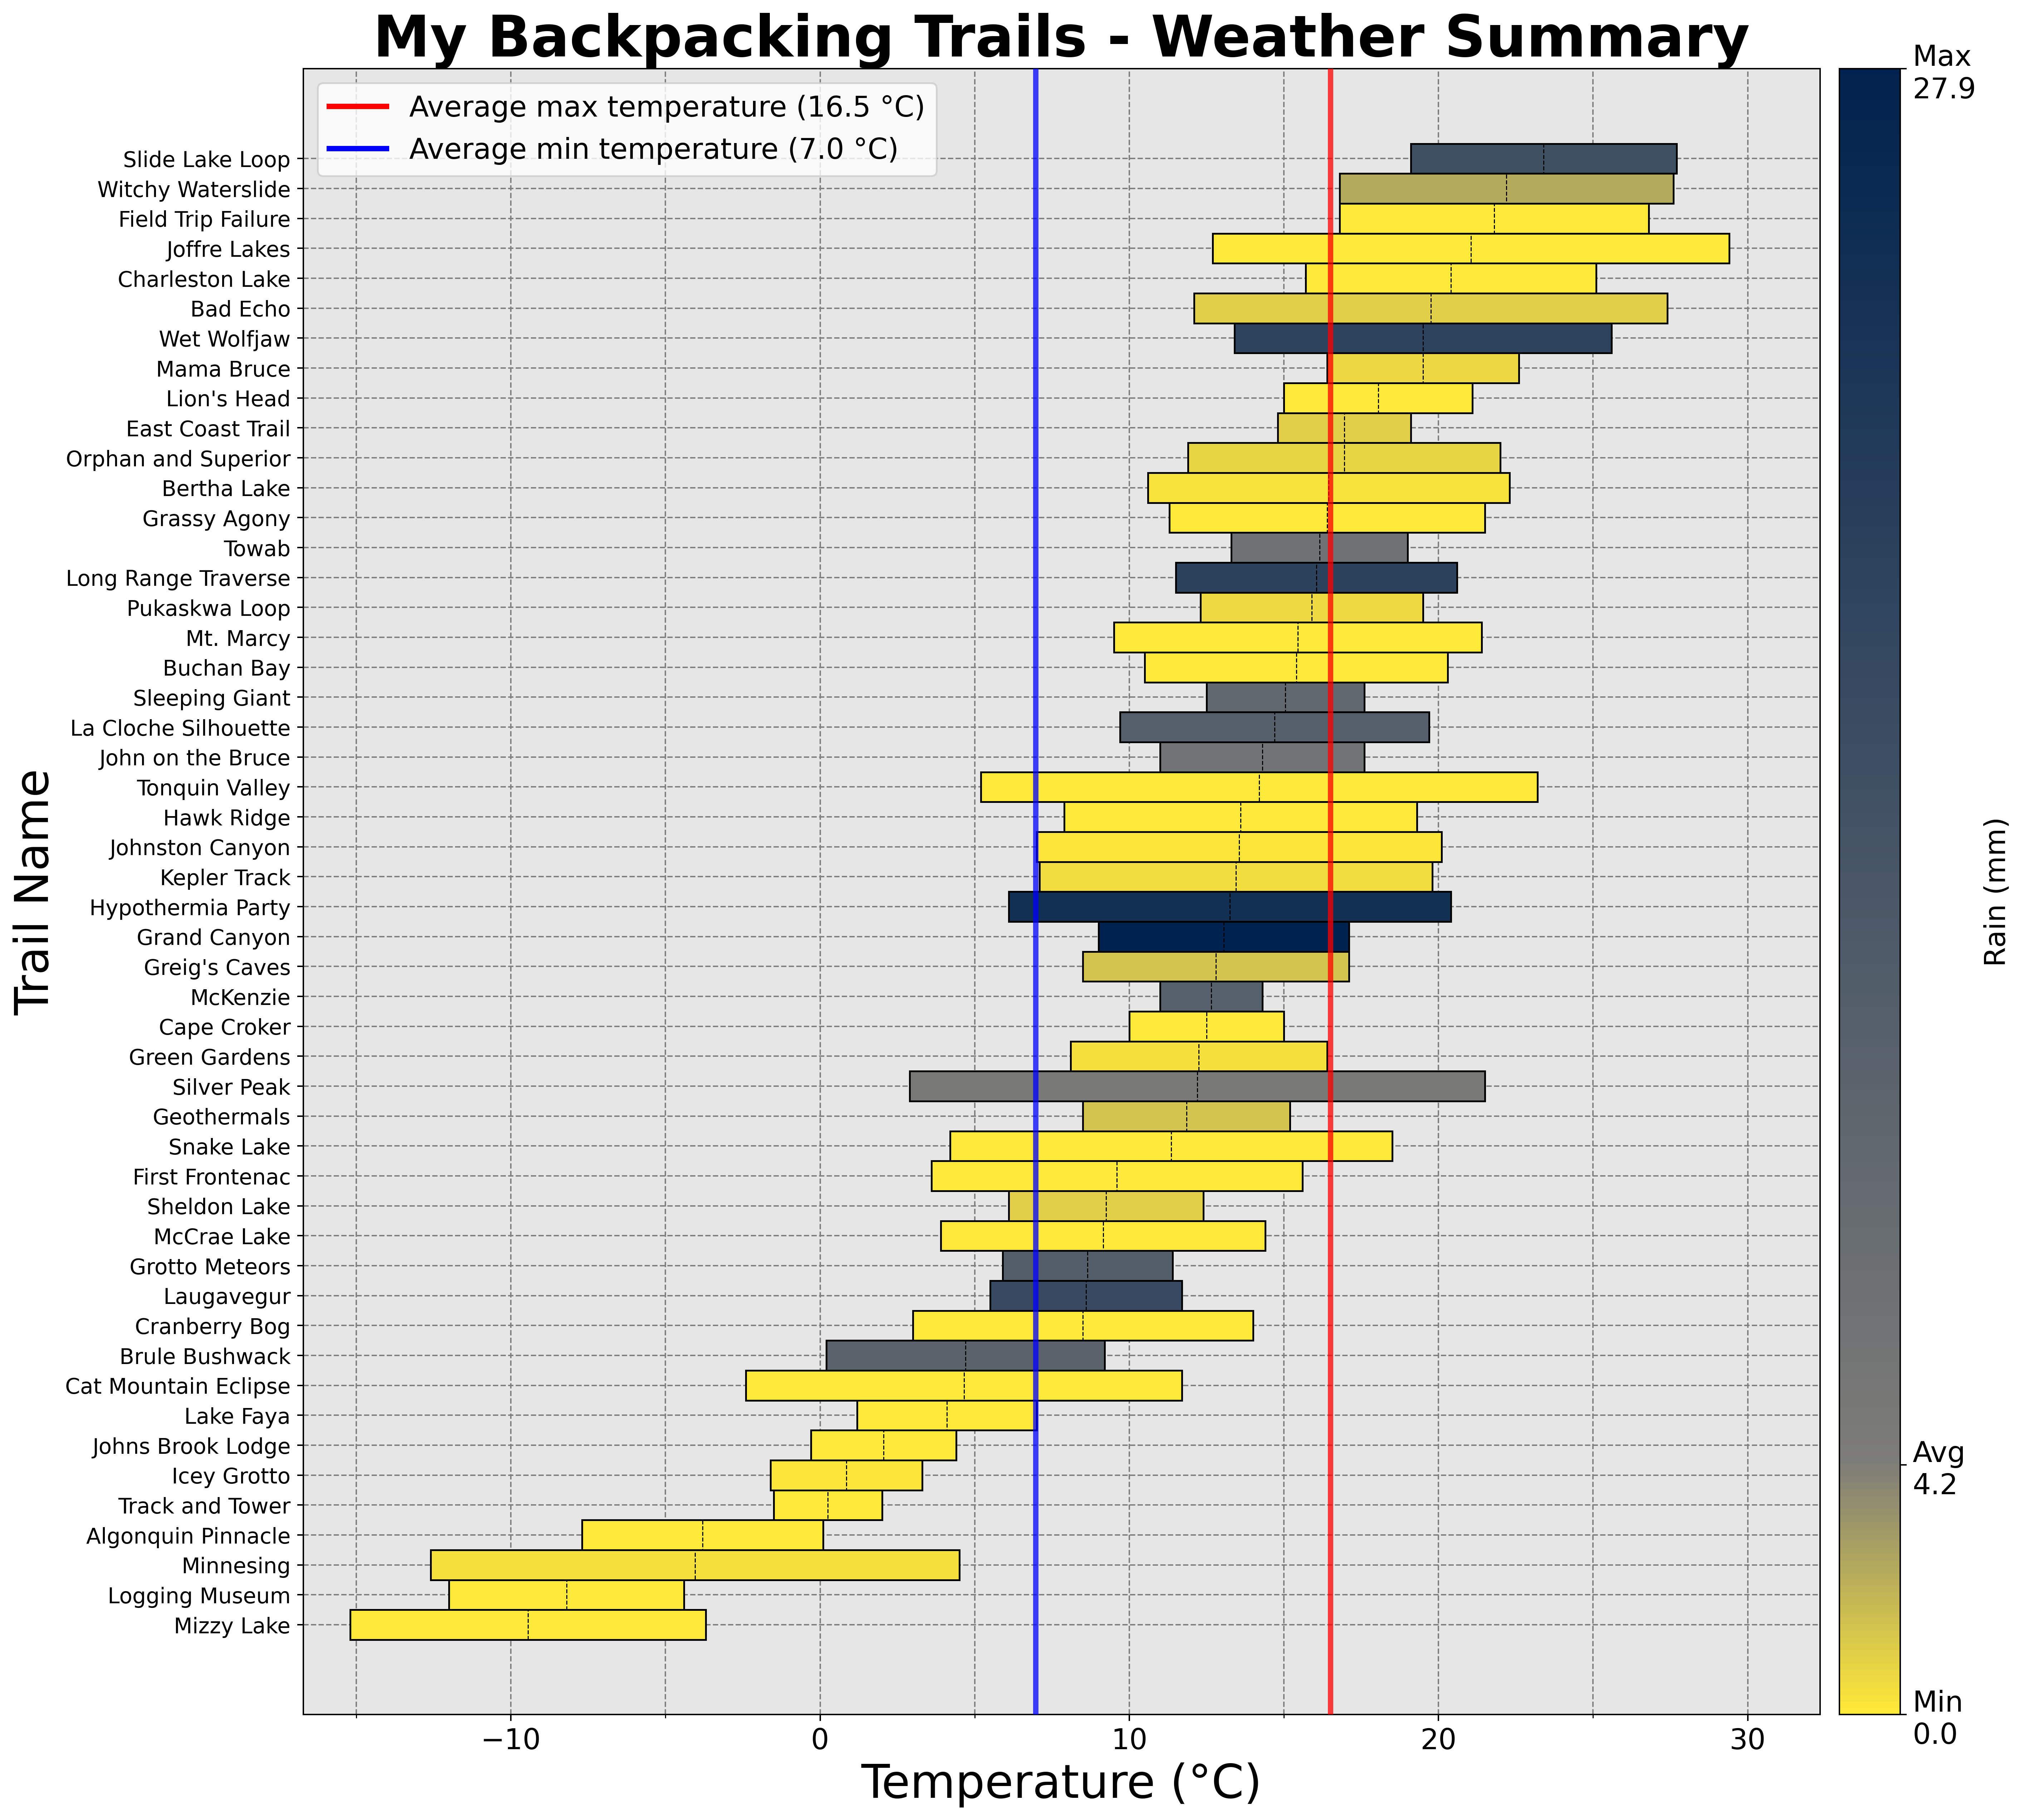

In [72]:
def colorBarPlot(trails, savePlot=False):
    numTrails = len(trails)
    tempAvg = (trails["max_temp"] + trails["min_temp"]) / 2
    trails = trails.assign(tempAvg=tempAvg).sort_values(by="tempAvg", ascending=True)
    
    fig, ax = plt.subplots(figsize=(standardCanvasWidth, 1.6 + numTrails * 0.3), dpi=DPI)
    ax.set_title("My Backpacking Trails - Weather Summary", size=titleSize, fontweight="bold")
    ax.set_xlabel("Temperature (°C)", size=axisLabelSize)
    ax.set_ylabel("Trail Name", size=axisLabelSize)
    
    ax.yaxis.set_major_locator(mticker.FixedLocator(range(numTrails)))
    ax.set_yticklabels(trails["trail_name"])
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.grid(axis="both", which="both", ls="--", c="grey", zorder=0)

    ax.tick_params(axis="x", labelsize=tickLabelSize)
    ax.tick_params(axis="y", labelsize=tickLabelSize - 4)

    avgMax, avgMin = trails["max_temp"].mean(), trails["min_temp"].mean()
    
    ax.axvline(avgMax, color="red", lw=3, zorder=4, alpha=0.75)
    ax.axvline(avgMin, color="blue", lw=3, zorder=4, alpha=0.75)
    
    legendItems = [
        Line2D([0], [0], color="red", lw=3, label=f"Average max temperature ({round(avgMax, 1)} °C)"),
        Line2D([0], [0], color="blue", lw=3, label=f"Average min temperature ({round(avgMin, 1)} °C)")
    ]
    ax.legend(facecolor=legendColor, prop={"size": legendTextSize}, handles=legendItems, loc="upper left")

    rain = trails["rain"]
    rMin, rMax, rAvg = rain.min(), rain.max(), rain.mean()
    diff = rMax - rMin
    mid = (rAvg - rMin) / diff if diff != 0 else 0.5
    
    cmap = mcolors.LinearSegmentedColormap.from_list("", [
        (0.0, cm.cividis(1.0)), 
        (mid, cm.cividis(0.5)), 
        (1.0, cm.cividis(0.0))
    ])

    normRain = (rain - rMin) / diff if diff != 0 else np.zeros(numTrails)
    ax.barh(
        trails["trail_name"], 
        trails["max_temp"] - trails["min_temp"], 
        left=trails["min_temp"], 
        color=cmap(normRain.astype(float)), 
        height=1, 
        edgecolor="k", 
        zorder=2
    )

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="4%", pad=0.15)
    
    sm = cm.ScalarMappable(cmap=cmap)
    cbar = fig.colorbar(sm, cax=cax, orientation="vertical", ticks=[0, mid, 1])
    cbar.set_label("Rain (mm)", size=tickLabelSize)
    cbar.ax.set_yticklabels([f"Min\n{round(rMin, 1)}", f"Avg\n{round(rAvg, 1)}", f"Max\n{round(rMax, 1)}"])
    cbar.ax.tick_params(labelsize=tickLabelSize)

    ySteps = np.arange(numTrails + 1) - 0.5
    xSteps = np.append(trails["tempAvg"], trails["tempAvg"].iloc[-1])
    ax.step(xSteps, ySteps, "k--", lw=0.6, where="pre", zorder=3)

    ax.set_xlim(trails["min_temp"].min() * 1.1, trails["max_temp"].max() * 1.1)

    fig.patch.set_facecolor("w")
    plt.rcParams["axes.facecolor"] = "0.9"
    
    if savePlot:
        plt.savefig("images/WeatherSummaryPlot", bbox_inches="tight")
    plt.show()

colorBarPlot(myTrails, savePlot=True)

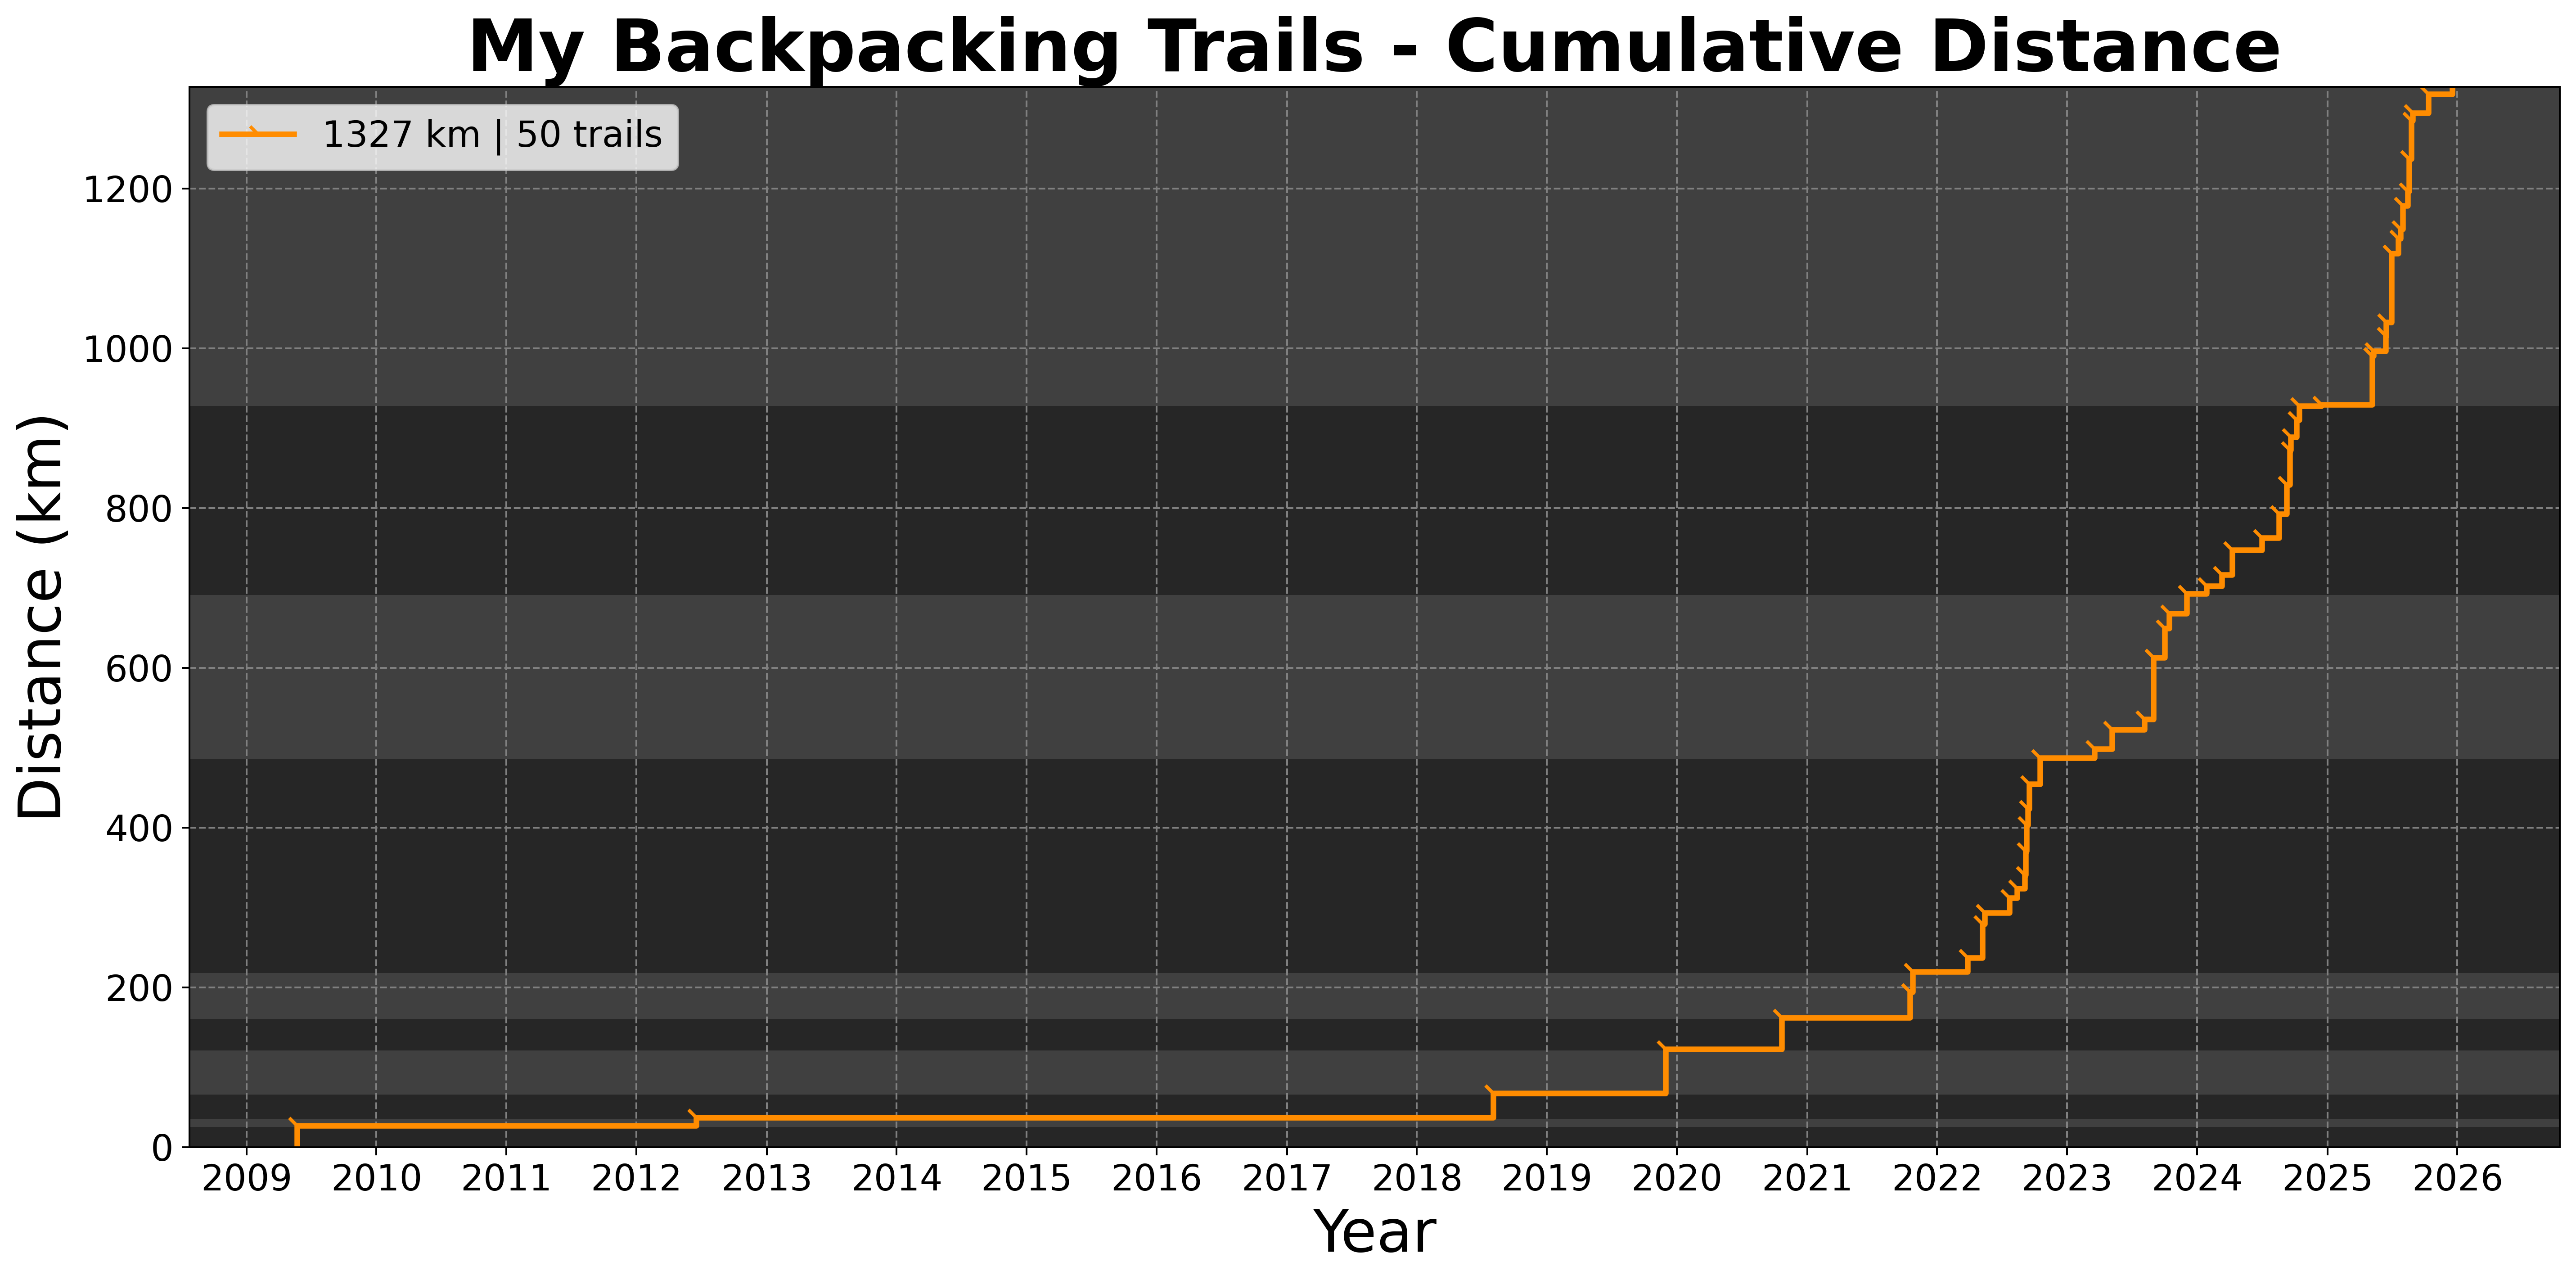

In [45]:
myDistCum = pd.concat([pd.Series([0]), myTrails.distance.cumsum()])
xDates = pd.concat([
    pd.Series([myTrails.end_date.iloc[0]]),
    myTrails.end_date
])

fig, ax = plt.subplots(figsize=(standardCanvasWidth, standardCanvasHeight), dpi=DPI)
title = "My Backpacking Trails - Cumulative Distance"
ax.set_title(title, size=titleSize, fontweight="bold")
ax.set_xlabel("Year", size=axisLabelSize)
ax.set_ylabel("Distance (km)", size=axisLabelSize)

plt.step(
    xDates,
    myDistCum,
    where="post",
    linewidth=2.5,
    markevery=(1, 1),
    marker=(1, 2, 45),
    markersize=10,
    mew=1.5,
    color="darkorange",
    zorder=2,
    label=f"{round(myTrails.distance.sum())} km | {len(myTrails)} trails"
)

# Add alternating year background spans
years = xDates.apply(lambda date: date.year).tolist()
distinctYears = [years[0]]
calendarYearBarRollingValue = 0

for i, (year, dist) in enumerate(zip(years, myDistCum)):
    nextYear = years[i + 1] if i + 1 < len(years) else None
    shadeColor = "0.25" if len(distinctYears) % 2 == 0 else "0.15"

    if nextYear and nextYear not in distinctYears:
        ax.axhspan(calendarYearBarRollingValue, dist, facecolor=shadeColor, edgecolor=shadeColor, zorder=0)
        calendarYearBarRollingValue = dist
        distinctYears.append(nextYear)
    elif i == len(years) - 1:
        ax.axhspan(calendarYearBarRollingValue, dist, facecolor=shadeColor, edgecolor=shadeColor, zorder=0)

ax.set_ylim(0, myDistCum.max())
ax.xaxis.set_major_locator(YearLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
ax.tick_params(axis="both", which="both", labelsize=tickLabelSize)
ax.grid(axis="both", which="both", linestyle="--", color="grey", zorder=1)

plt.legend(facecolor=legendColor, prop={"size": legendTextSize}, loc="upper left")
plt.rcParams["axes.facecolor"] = backgroundColor
fig.patch.set_facecolor("w")
plt.tight_layout()
plt.savefig(f"images/{title.replace(' ', '')}")
plt.show()

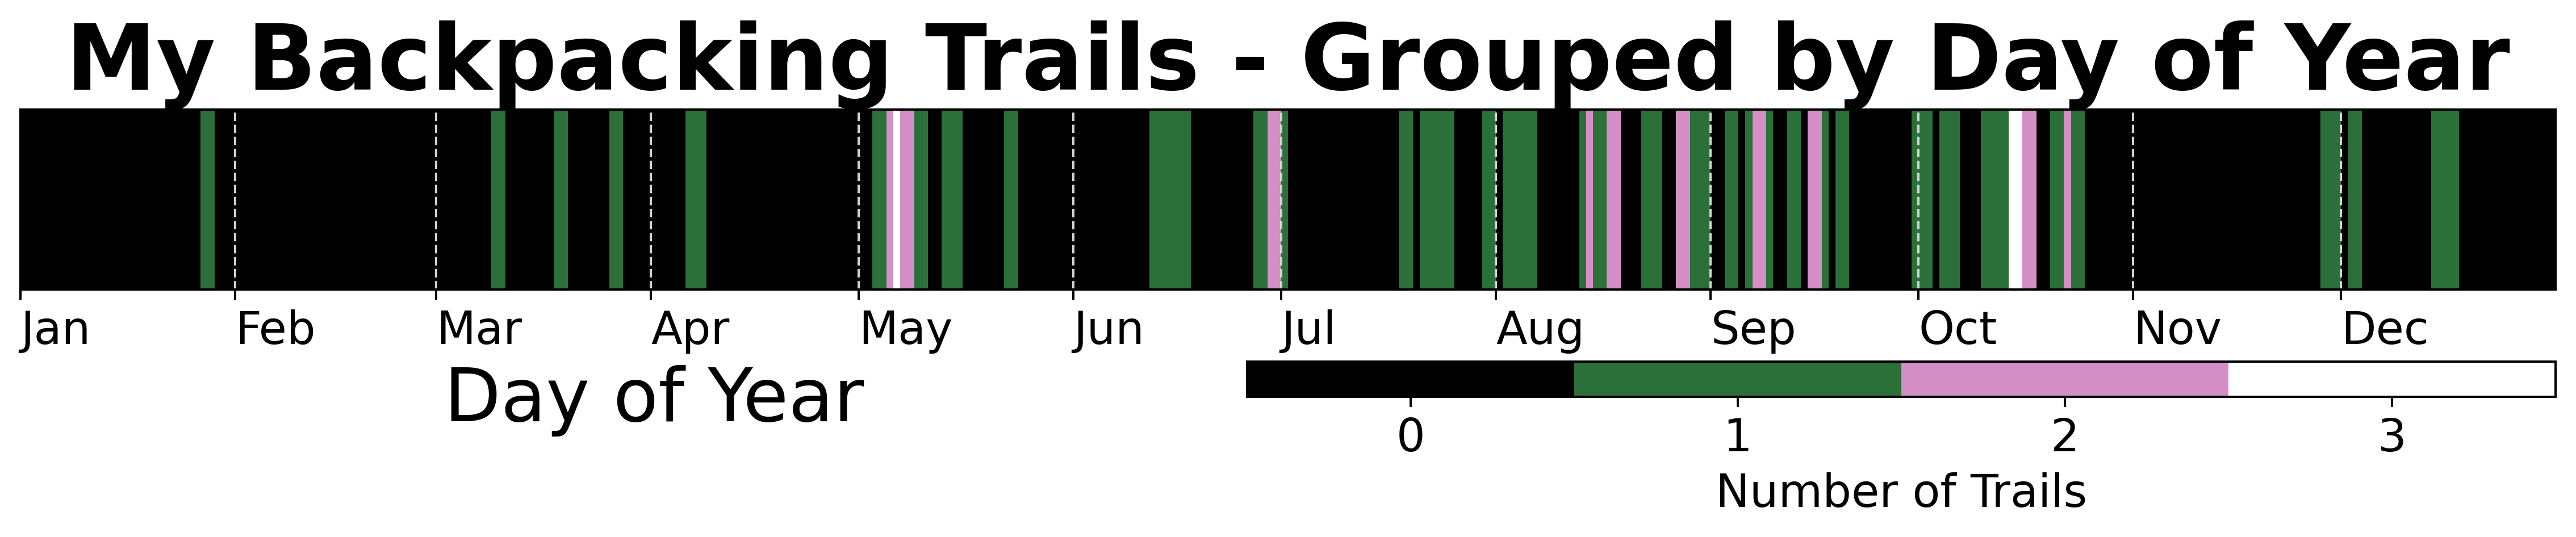

In [46]:
def addTrailToCounts(trail, counts):
    trailDateRange = pd.date_range(trail.start_date, trail.end_date, freq="d")
    for trailDate in trailDateRange:
        # Adjust for leap year
        if not calendar.isleap(trailDate.year) and trailDate.month > 2:
            counts[trailDate.timetuple().tm_yday] += 1
        else:
            counts[trailDate.timetuple().tm_yday - 1] += 1

trailCounts = np.zeros(366)
myTrails.apply(lambda trail: addTrailToCounts(trail, trailCounts), axis=1)

# Prepare Dates and Colormap
leapYear = dt.datetime(2020, 1, 1)  # Arbitrary leap year
periods = [leapYear + dt.timedelta(days=i) for i in range(366)]
cmap = plt.get_cmap("cubehelix", trailCounts.max() + 1)

# Plot Setup
fig = plt.figure(figsize=(standardCanvasWidth, standardCanvasHeight / 7))
fig.set_dpi(DPI)
ax = plt.gca()

# Draw Bar Plot
ax.bar(
    periods, 1, align="edge", width=1, linewidth=0,
    color=cmap(trailCounts / trailCounts.max()), zorder=0
)

# X-axis Formatting
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter("%b"))
ax.set_xlim(periods[0], periods[-1] + dt.timedelta(hours=23))
for label in ax.xaxis.get_ticklabels():
    label.set_horizontalalignment("left")
ax.xaxis.set_tick_params(labelsize=tickLabelSize)

# Grid and Labels 
plt.grid(axis="x", which="both", ls="--", c="lightgrey", zorder=1)
ax.set_title("My Backpacking Trails - Grouped by Day of Year", size=titleSize, fontweight="bold")
ax.set_xlabel("Day of Year", size=axisLabelSize, x=0.25)
plt.yticks([])
plt.ylim(0, 1)

# Colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, max(trailCounts)))
n_clusters = max(trailCounts) + 1
tick_locs = (np.arange(n_clusters) + 0.5) * (n_clusters - 1) / n_clusters
cbar = plt.colorbar(
    sm, orientation="horizontal",
    cax=fig.add_axes([0.5, -0.35, 0.4, 0.15])
)
cbar.set_label("Number of Trails", size=tickLabelSize)
cbar.set_ticks(tick_locs)
cbar.ax.tick_params(labelsize=tickLabelSize)
cbar.set_ticklabels(range(int(n_clusters)))

plt.savefig("images/TrailDensityByDay.png", bbox_inches="tight")

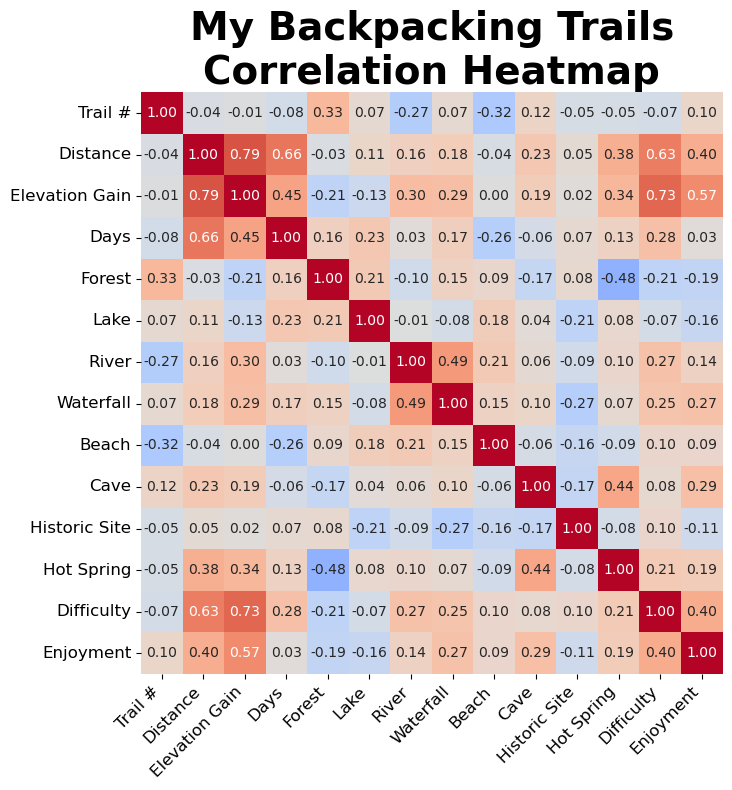

In [47]:
def correlationHeatmap(trails,
                       columns,
                       columnLabels,
                       plotTitle,
                       savePlot=False):

    corrMatrix = (
        trails[columns]
        .rename(columns=columnLabels)
        .corr()
    )

    plt.figure(figsize=(8, 8))

    sns.heatmap(
        corrMatrix,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        square=True,
        cbar=False,
        annot_kws={"size": 10},
        vmin=-1,
        vmax=1
    )

    plt.title(plotTitle, size=28, fontweight="bold")
    plt.xticks(rotation=45, ha="right", size=12)
    plt.yticks(rotation=0, size=12)
    plt.tight_layout()

    if savePlot:
        plt.savefig(f"images/{plotTitle.replace(' ', '')}")

    plt.show()

myHeatmapColumns = ["order", "distance", "elevation_gain", "days",
                    "forest", "lake", "river", "waterfall", "beach", "cave", "historic_site", "hot_spring",
                    "difficulty", "enjoyment"]

myHeatmapColumnNameMap = {
    "order": "Trail #",
    "distance": "Distance",
    "elevation_gain": "Elevation Gain",
    "days": "Days",
    "forest": "Forest",
    "lake": "Lake",
    "river": "River",
    "waterfall": "Waterfall",
    "beach": "Beach",
    "cave": "Cave",
    "historic_site": "Historic Site",
    "hot_spring": "Hot Spring",
    "difficulty": "Difficulty",
    "enjoyment": "Enjoyment"
}

correlationHeatmap(
    myTrails,
    myHeatmapColumns,
    myHeatmapColumnNameMap,
    "My Backpacking Trails\nCorrelation Heatmap",
    savePlot=True
)

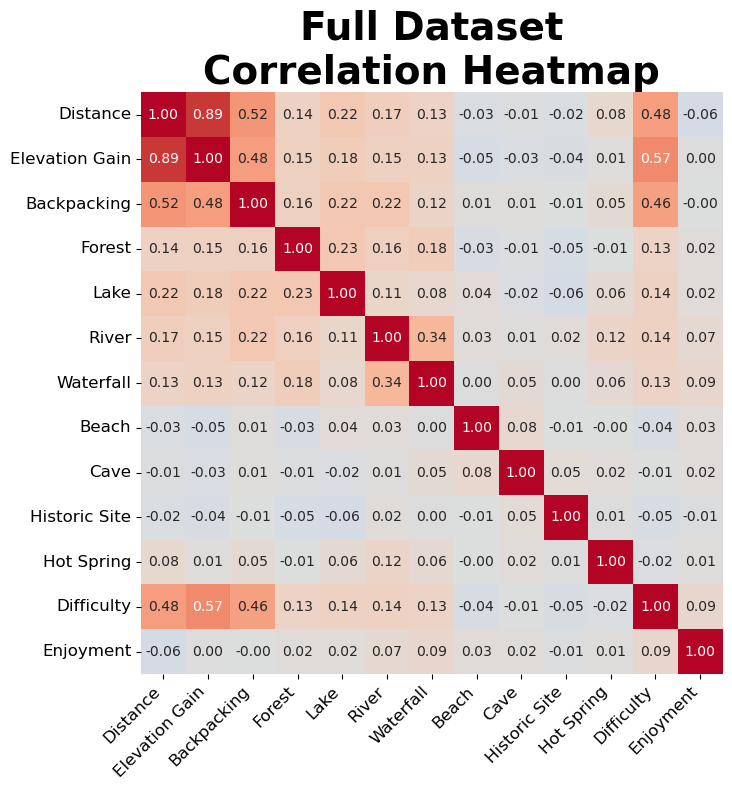

In [48]:
masterHeatmapColumns = ["distance", "elevation_gain", "backpacking",
                        "forest", "lake", "river", "waterfall", "beach", "cave", "historic_site", "hot_spring",
                        "difficulty", "enjoyment"]

masterHeatmapColumnNameMap = {
    "distance": "Distance",
    "elevation_gain": "Elevation Gain",
    "backpacking": "Backpacking",
    "days": "Days",
    "forest": "Forest",
    "lake": "Lake",
    "river": "River",
    "waterfall": "Waterfall",
    "beach": "Beach",
    "cave": "Cave",
    "historic_site": "Historic Site",
    "hot_spring": "Hot Spring",
    "difficulty": "Difficulty",
    "enjoyment": "Enjoyment"
}

correlationHeatmap(
    masterTrails,
    masterHeatmapColumns,
    masterHeatmapColumnNameMap,
    "Full Dataset\nCorrelation Heatmap",
    savePlot=True
)

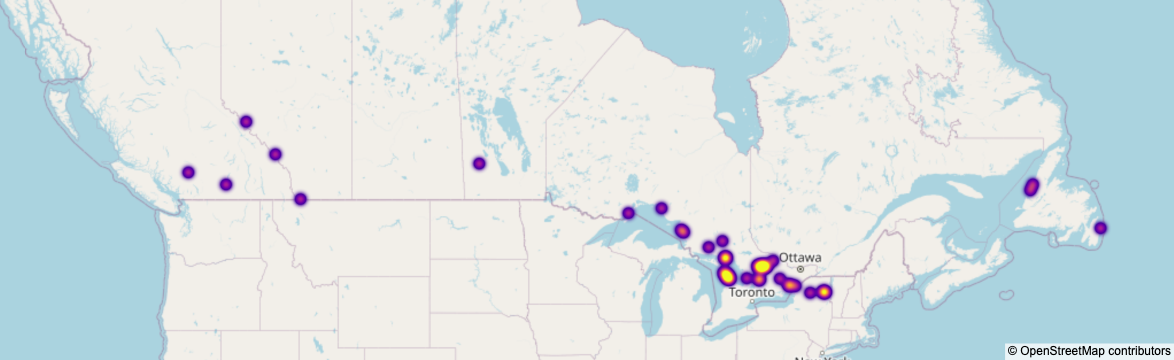

In [70]:
fig = px.density_mapbox(myTrails, 
                        lat="latitude",
                        lon="longitude",
                        radius=10,
                        center=dict(lat=50, lon=-92),
                        zoom=3.2,
                        mapbox_style="open-street-map")

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update(layout_coloraxis_showscale=False)
fig.show()

---

# Training Difficulty Model

### Choosing Splits

In [50]:
testSplit = 0.15

trainSplit = 1 - testSplit

print(f"Training Counts ({round(trainSplit, 2)} of data):")
print((masterTrails.difficulty.value_counts()*trainSplit).astype("int").sort_index())
print(f"\nTesting Counts ({round(testSplit, 2)} of data):")
print((masterTrails.difficulty.value_counts()*testSplit).astype("int").sort_index())

Training Counts (0.85 of data):
difficulty
1     673
3    1183
5     659
7     164
Name: count, dtype: int64

Testing Counts (0.15 of data):
difficulty
1    118
3    208
5    116
7     29
Name: count, dtype: int64


### Splitting Data

In [51]:
xDifficulty = masterTrails[xCols]
yDifficulty = masterTrails.difficulty

xTrainDifficulty, xTestDifficulty, yTrainDifficulty, yTestDifficulty = train_test_split(xDifficulty, 
                                                                                        yDifficulty, 
                                                                                        test_size=testSplit, 
                                                                                        stratify=yDifficulty, # Stratify on user too?
                                                                                        random_state=seed)

### Encoding and Standardizing

In [52]:
difficultyPreprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), continuousCols),
        ("bin", "passthrough", binaryCols),
        ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), categoricalCols)
    ]
)

xTrainDifficulty = difficultyPreprocessor.fit_transform(xTrainDifficulty)
xTestDifficulty = difficultyPreprocessor.transform(xTestDifficulty)

encodedFeatureNamesDifficulty = np.concatenate([
    continuousCols, 
    binaryCols, 
    difficultyPreprocessor.named_transformers_["cat"].get_feature_names_out(categoricalCols)
])

xTrainDifficulty = pd.DataFrame(xTrainDifficulty, columns=encodedFeatureNamesDifficulty)
xTestDifficulty = pd.DataFrame(xTestDifficulty, columns=encodedFeatureNamesDifficulty)

### Testing Potential Model Types

In [53]:
def testDefaultRegressors(xTrain, xTest, yTrain, yTest):
    
    models = [
        (LinearRegression(), "Linear Regression"),
        (KNeighborsRegressor(), "KNN"),
        (Lasso(), "Lasso"),
        (ElasticNet(), "Elastic Net"),
        (Ridge(), "Ridge"),
        (SVR(kernel="rbf"), "SVR rbf"),
        (RandomForestRegressor(), "Random Forest Regressor"),
        (GradientBoostingRegressor(), "Gradient Boosting Regressor"),
        (BaggingRegressor(), "Bagging Regressor")
    ]
    
    results = []
    
    for model, name in models:
        model.fit(xTrain, yTrain)
        mse = mean_squared_error(yTest, model.predict(xTest))
        results.append((name, mse))
    
    results.sort(key=lambda x: x[1])
    
    for name, mse in results:
        print(f"{name}: {round(mse, 3)}")

testDefaultRegressors(xTrainDifficulty, xTestDifficulty, yTrainDifficulty, yTestDifficulty)

Gradient Boosting Regressor: 1.0
Random Forest Regressor: 1.064
SVR rbf: 1.086
Bagging Regressor: 1.152
KNN: 1.602
Ridge: 1.623
Linear Regression: 1.63
Elastic Net: 2.363
Lasso: 2.915


### Gradient Boosting Regressor

In [54]:
def getFeatureImportances(model, featureNames):

    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    elif hasattr(model, "coef_"):
        importances = np.abs(model.coef_)
    else:
        raise ValueError("Model does not expose importances")

    return pd.Series(importances, index=featureNames)

def featureImportancesAggregated(model, featureNames):
    importances = getFeatureImportances(model, featureNames)

    aggImportances = importances.copy()

    if categoricalCols:
        for prefix in categoricalCols:
            columns = [col for col in aggImportances.index if col.startswith(prefix)]
            if columns:
                aggImportances[prefix] = aggImportances[columns].sum()
                aggImportances = aggImportances.drop(columns)

    return aggImportances.sort_values(ascending=False)

def recursiveMseReduction(model, xTrain, xTest, yTrain, yTest):

    currentXTrain = xTrain.copy()
    currentXTest = xTest.copy()
    
    # Get initial baseline
    model.fit(currentXTrain, yTrain)
    bestMse = mean_squared_error(yTest, model.predict(currentXTest))
    
    print(f"Initial Baseline MSE: {bestMse:.6f}")
    removedFeatures = []

    while True:
        # Identify all unique 'logical' features currently in the dataset
        allCols = currentXTrain.columns.tolist()
        logicalFeatures = []
        seenPrefixes = set()

        for col in allCols:
            # Check if this column belongs to a categorical group
            foundPrefix = False
            for prefix in categoricalCols:
                if col.startswith(prefix):
                    if prefix not in seenPrefixes:
                        logicalFeatures.append(('categorical', prefix))
                        seenPrefixes.add(prefix)
                    foundPrefix = True
                    break
            
            # If it's not categorical, treat it as a standalone feature
            if not foundPrefix:
                logicalFeatures.append(('standalone', col))

        bestIterationMse = bestMse
        featureToDropThisRound = None
        colsToDropThisRound = []

        # Exhaustively test every logical feature group
        for featType, name in logicalFeatures:
            if featType == 'categorical':
                testDrop = [c for c in allCols if c.startswith(name)]
            else:
                testDrop = [name]

            # Tentative drop
            tempXTrain = currentXTrain.drop(columns=testDrop)
            tempXTest = currentXTest.drop(columns=testDrop)
            
            model.fit(tempXTrain, yTrain)
            trialMse = mean_squared_error(yTest, model.predict(tempXTest))

            # Track which removal yields the lowest MSE
            if trialMse < bestIterationMse:
                bestIterationMse = trialMse
                featureToDropThisRound = name
                colsToDropThisRound = testDrop

        # If we found a removal that improves the MSE
        if featureToDropThisRound is not None:
            print(f"REMOVING: {featureToDropThisRound} | MSE: {bestMse:.6f} -> {bestIterationMse:.6f}")
            bestMse = bestIterationMse
            currentXTrain = currentXTrain.drop(columns=colsToDropThisRound)
            currentXTest = currentXTest.drop(columns=colsToDropThisRound)
            removedFeatures.extend(colsToDropThisRound)
        else:
            print("STOPPING: No further feature removal reduces MSE.")
            break

    return model.fit(currentXTrain, yTrain), bestMse, removedFeatures

def getBestModelFromCV(model, cvGrid, xTrain, yTrain):

    defaultParams = model.get_params()
    defaultParamsFocused = {key: defaultParams[key] for key in cvGrid.keys() if key in defaultParams}
    print(f"Default Parameters: {defaultParamsFocused}")
    
    gridSearch = GridSearchCV(
        estimator=model,
        param_grid=cvGrid,
        cv=KFold(n_splits=5, shuffle=True, random_state=seed),
        scoring="neg_mean_squared_error",
        n_jobs=1,
        verbose=0
    )
    
    gridSearch.fit(xTrain, yTrain)
    
    print(f"Best Parameters: {gridSearch.best_params_}")
    
    return gridSearch.best_estimator_

def roundDifficulties(difficulties):
    
    scale = np.array([1, 3, 5, 7])

    roundedDifficulties = []
    for difficulty in difficulties:
        roundedDifficulties.append(scale[np.argmin(np.abs(scale - difficulty))])

    return roundedDifficulties

def getDifficultyAccuracy(model, xTest, yTest):
    return np.mean(roundDifficulties(model.predict(xTest)) == yTest)

def assessDifficultyModel(model, xTest, yTest):

    mse = mean_squared_error(yTest, model.predict(xTest))
    accuracy = getDifficultyAccuracy(model, xTest, yTest)
    
    print(f"MSE: {mse}")
    print(f"Accuracy: {accuracy}")

    return mse, accuracy

def roundEnjoyments(enjoyments):
    
    scale = np.array([1, 2, 3, 4, 5])

    roundedEnjoyments = []
    for enjoyment in enjoyments:
        roundedEnjoyments.append(scale[np.argmin(np.abs(scale - enjoyment))])

    return roundedEnjoyments

def getEnjoymentAccuracy(model, xTest, yTest):
    return np.mean(np.abs(model.predict(xTest) - yTest) <= 0.5)

def assessEnjoymentModel(model, xTest, yTest):

    mse = mean_squared_error(yTest, model.predict(xTest))
    accuracy = getEnjoymentAccuracy(model, xTest, yTest)
    
    print(f"MSE: {mse}")
    print(f"Accuracy: {accuracy}")

    return mse, accuracy

def trainModel(model, xTrain, xTest, yTrain, yTest, cvGrid, assessment):

    print("----- FEATURE SELECTION -----")
    
    baseModel, baseMSE, badFeatures = recursiveMseReduction(
        model, 
        xTrain, 
        xTest, 
        yTrain, 
        yTest
    )
    
    xTrainTrimmed = xTrain.drop(columns=badFeatures)
    xTestTrimmed = xTest.drop(columns=badFeatures)
    
    print("\n----- HYPERPARAMETER TUNING -----")
    
    cvModel = getBestModelFromCV(
        model, 
        cvGrid, 
        xTrainTrimmed, 
        yTrain
    )

    bestModel = cvModel
    if baseMSE < mean_squared_error(yTest, cvModel.predict(xTestTrimmed)):
        bestModel = baseModel
    
    print("\n----- MODEL ASSESSMENT -----")

    bestMse, bestAccuracy = assessment(bestModel, xTestTrimmed, yTest)

    if hasattr(bestModel, "feature_importances_") or hasattr(bestModel, "coef_"):
        
        print("\n----- FEATURE IMPORTANCE -----")
        
        print(featureImportancesAggregated(bestModel, xTrainTrimmed.columns))

    return bestModel, bestMse, bestAccuracy, badFeatures

In [55]:
cvGridGBR = {
    "n_estimators": [100, 500, 1000],   # Number of boosting stages
    "learning_rate": [0.01, 0.05, 0.1], # Shrinkage (step size)
    "max_depth": [3, 4, 6],             # Depth of individual trees
    "min_samples_split": [2, 5],        # Minimum samples to split a node
    "subsample": [0.8, 1.0]             # Stochastic gradient boosting (prevents overfitting)
}

difficultyModelGBR, difficultyMseGBR, difficultyAccuracyGBR, difficultyBadFeaturesGBR = trainModel(
    GradientBoostingRegressor(random_state=seed), 
    xTrainDifficulty, 
    xTestDifficulty, 
    yTrainDifficulty, 
    yTestDifficulty,
    cvGridGBR,
    assessDifficultyModel
)

----- FEATURE SELECTION -----
Initial Baseline MSE: 1.000522
REMOVING: backpacking | MSE: 1.000522 -> 0.986207
REMOVING: user | MSE: 0.986207 -> 0.977410
REMOVING: forest | MSE: 0.977410 -> 0.973166
REMOVING: hot_spring | MSE: 0.973166 -> 0.972872
REMOVING: beach | MSE: 0.972872 -> 0.972841
STOPPING: No further feature removal reduces MSE.

----- HYPERPARAMETER TUNING -----
Default Parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'subsample': 1.0}
Best Parameters: {'learning_rate': 0.01, 'max_depth': 4, 'min_samples_split': 5, 'n_estimators': 500, 'subsample': 0.8}

----- MODEL ASSESSMENT -----
MSE: 0.9728413986701501
Accuracy: 0.7172995780590717

----- FEATURE IMPORTANCE -----
elevation_gain    0.891676
distance          0.027354
winter_temp       0.015555
park              0.015506
summer_temp       0.012819
province          0.010073
annual_snow       0.008499
annual_rain       0.007830
route_type        0.003946
waterfall         0.002

### Random Forest Regressor

In [56]:
cvGridRFR = {
    "n_estimators": [300, 600],   # Number of boosting stages
    "max_depth": [None, 20],      # Depth of individual trees
    "min_samples_leaf": [1, 3],   # Controls leaf size
    "max_features": ["sqrt", 0.5] # Controls feature randomness at splits
}

difficultyModelRFR, difficultyMseRFR, difficultyAccuracyRFR, difficultyBadFeaturesRFR = trainModel(
    RandomForestRegressor(random_state=seed), 
    xTrainDifficulty, 
    xTestDifficulty, 
    yTrainDifficulty, 
    yTestDifficulty,
    cvGridRFR,
    assessDifficultyModel
)

----- FEATURE SELECTION -----
Initial Baseline MSE: 1.060122
REMOVING: annual_rain | MSE: 1.060122 -> 1.048036
REMOVING: forest | MSE: 1.048036 -> 1.042381
REMOVING: historic_site | MSE: 1.042381 -> 1.033288
REMOVING: hot_spring | MSE: 1.033288 -> 1.026295
STOPPING: No further feature removal reduces MSE.

----- HYPERPARAMETER TUNING -----
Default Parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_leaf': 1, 'max_features': 1.0}
Best Parameters: {'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 3, 'n_estimators': 600}

----- MODEL ASSESSMENT -----
MSE: 1.002338628752035
Accuracy: 0.7172995780590717

----- FEATURE IMPORTANCE -----
elevation_gain    0.564641
distance          0.195357
winter_temp       0.042387
backpacking       0.042382
summer_temp       0.041495
annual_snow       0.031627
park              0.023938
province          0.021014
route_type        0.017335
river             0.005965
waterfall         0.005022
lake              0.005009
user         

### Support Vector Regression

In [57]:
cvGridSVR = {
    "C": [0.01, 0.1, 1, 10, 100], # Regularization strength
    "epsilon": [0.01, 0.1, 0.5],  # Width of error-free tube
    "gamma": ["scale", 0.01, 0.1] # Kernel coefficient
}
    
difficultyModelSVR, difficultyMseSVR, difficultyAccuracySVR, difficultyBadFeaturesSVR = trainModel(
    SVR(kernel="rbf"), 
    xTrainDifficulty, 
    xTestDifficulty, 
    yTrainDifficulty, 
    yTestDifficulty,
    cvGridSVR,
    assessDifficultyModel
)

----- FEATURE SELECTION -----
Initial Baseline MSE: 1.085781
REMOVING: park | MSE: 1.085781 -> 1.052370
REMOVING: summer_temp | MSE: 1.052370 -> 1.045792
REMOVING: annual_rain | MSE: 1.045792 -> 1.036201
REMOVING: forest | MSE: 1.036201 -> 1.031110
REMOVING: hot_spring | MSE: 1.031110 -> 1.026650
REMOVING: cave | MSE: 1.026650 -> 1.025790
REMOVING: historic_site | MSE: 1.025790 -> 1.022783
STOPPING: No further feature removal reduces MSE.

----- HYPERPARAMETER TUNING -----
Default Parameters: {'C': 1.0, 'epsilon': 0.1, 'gamma': 'scale'}
Best Parameters: {'C': 1, 'epsilon': 0.5, 'gamma': 'scale'}

----- MODEL ASSESSMENT -----
MSE: 1.022783362168815
Accuracy: 0.7067510548523207


### Comparing Models

In [58]:
difficultyModelLabels = ["Gradient Boosting Regressor", "Random Forest Regressor", "Support Vector Regression"]
difficultyMSEs = [difficultyMseGBR, difficultyMseRFR, difficultyMseSVR]
difficultyAccuracies = [difficultyAccuracyGBR, difficultyAccuracyRFR, difficultyAccuracySVR]

difficultyModelComparisons = pd.DataFrame({
    "Model": difficultyModelLabels,
    "MSE": difficultyMSEs,
    "Accuracy": difficultyAccuracies
})

difficultyModelComparisons

Model       MSE  Accuracy
0  Gradient Boosting Regressor  0.972841  0.717300
1      Random Forest Regressor  1.002339  0.717300
2    Support Vector Regression  1.022783  0.706751

---

# Training Enjoyment Model

### Splitting Data

In [59]:
enjoymentTrails = masterTrails.query("enjoyment != 0")

xEnjoyment = enjoymentTrails[xCols]
yEnjoyment = enjoymentTrails.enjoyment

xTrainEnjoyment, xTestEnjoyment, yTrainEnjoyment, yTestEnjoyment = train_test_split(xEnjoyment, 
                                                                                    yEnjoyment, 
                                                                                    test_size=testSplit, 
                                                                                    stratify=yEnjoyment,
                                                                                    random_state=seed)

### Encoding and Standardizing

In [60]:
enjoymentPreprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), continuousCols),
        ("bin", "passthrough", binaryCols),
        ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), categoricalCols)
    ]
)

xTrainEnjoyment = enjoymentPreprocessor.fit_transform(xTrainEnjoyment)
xTestEnjoyment = enjoymentPreprocessor.transform(xTestEnjoyment)

encodedFeatureNamesEnjoyment = np.concatenate([
    continuousCols, 
    binaryCols, 
    enjoymentPreprocessor.named_transformers_["cat"].get_feature_names_out(categoricalCols)
])

xTrainEnjoyment = pd.DataFrame(xTrainEnjoyment, columns=encodedFeatureNamesEnjoyment)
xTestEnjoyment = pd.DataFrame(xTestEnjoyment, columns=encodedFeatureNamesEnjoyment)

### Testing Potential Model Types

In [61]:
testDefaultRegressors(xTrainEnjoyment, xTestEnjoyment, yTrainEnjoyment, yTestEnjoyment)

Gradient Boosting Regressor: 0.202
SVR rbf: 0.205
Ridge: 0.21
Random Forest Regressor: 0.212
Linear Regression: 0.212
Bagging Regressor: 0.223
KNN: 0.223
Lasso: 0.293
Elastic Net: 0.293


### Gradient Boosting Regressor

In [62]:
enjoymentModelGBR, enjoymentMseGBR, enjoymentAccuracyGBR, enjoymentBadFeaturesGBR = trainModel(
    GradientBoostingRegressor(random_state=seed), 
    xTrainEnjoyment, 
    xTestEnjoyment, 
    yTrainEnjoyment, 
    yTestEnjoyment,
    cvGridGBR,
    assessEnjoymentModel
)

----- FEATURE SELECTION -----
Initial Baseline MSE: 0.202262
REMOVING: user | MSE: 0.202262 -> 0.199930
REMOVING: route_type | MSE: 0.199930 -> 0.198651
REMOVING: historic_site | MSE: 0.198651 -> 0.198056
REMOVING: forest | MSE: 0.198056 -> 0.197445
STOPPING: No further feature removal reduces MSE.

----- HYPERPARAMETER TUNING -----
Default Parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'subsample': 1.0}
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 1.0}

----- MODEL ASSESSMENT -----
MSE: 0.1974451433135124
Accuracy: 0.8165938864628821

----- FEATURE IMPORTANCE -----
elevation_gain    0.322088
summer_temp       0.150020
country           0.145344
winter_temp       0.098628
distance          0.068108
park              0.067506
annual_rain       0.065150
province          0.037130
annual_snow       0.022832
waterfall         0.012729
hot_spring        0.003498
beach       

### Support Vector Regression

In [63]:
enjoymentModelSVR, enjoymentMseSVR, enjoymentAccuracySVR, enjoymentBadFeaturesSVR = trainModel(
    SVR(kernel="rbf"), 
    xTrainEnjoyment, 
    xTestEnjoyment, 
    yTrainEnjoyment, 
    yTestEnjoyment,
    cvGridSVR,
    assessEnjoymentModel
)

----- FEATURE SELECTION -----
Initial Baseline MSE: 0.205175
REMOVING: route_type | MSE: 0.205175 -> 0.202349
REMOVING: river | MSE: 0.202349 -> 0.199885
REMOVING: annual_rain | MSE: 0.199885 -> 0.197648
REMOVING: winter_temp | MSE: 0.197648 -> 0.194901
REMOVING: hot_spring | MSE: 0.194901 -> 0.194226
REMOVING: user | MSE: 0.194226 -> 0.193656
REMOVING: beach | MSE: 0.193656 -> 0.192995
REMOVING: distance | MSE: 0.192995 -> 0.192294
STOPPING: No further feature removal reduces MSE.

----- HYPERPARAMETER TUNING -----
Default Parameters: {'C': 1.0, 'epsilon': 0.1, 'gamma': 'scale'}
Best Parameters: {'C': 10, 'epsilon': 0.5, 'gamma': 0.01}

----- MODEL ASSESSMENT -----
MSE: 0.19229425596182964
Accuracy: 0.8231441048034934


### Ridge

In [64]:
cvGridRidge = {
    "alpha": [0.01, 0.1, 1.0, 10.0, 100.0], # Regularization strength
    "fit_intercept": [True, False],         # Whether to fit an intercept term
    "solver": ["auto", "svd", "cholesky"]   # Algorithm used for optimization
}

enjoymentModelRidge, enjoymentMseRidge, enjoymentAccuracyRidge, enjoymentBadFeaturesRidge = trainModel(
    Ridge(), 
    xTrainEnjoyment, 
    xTestEnjoyment, 
    yTrainEnjoyment, 
    yTestEnjoyment, 
    cvGridRidge, 
    assessEnjoymentModel
)

----- FEATURE SELECTION -----
Initial Baseline MSE: 0.209924
REMOVING: user | MSE: 0.209924 -> 0.206853
REMOVING: annual_rain | MSE: 0.206853 -> 0.204927
REMOVING: winter_temp | MSE: 0.204927 -> 0.203385
REMOVING: hot_spring | MSE: 0.203385 -> 0.202496
REMOVING: backpacking | MSE: 0.202496 -> 0.201816
REMOVING: beach | MSE: 0.201816 -> 0.201542
REMOVING: distance | MSE: 0.201542 -> 0.201463
STOPPING: No further feature removal reduces MSE.

----- HYPERPARAMETER TUNING -----
Default Parameters: {'alpha': 1.0, 'fit_intercept': True, 'solver': 'auto'}
Best Parameters: {'alpha': 1.0, 'fit_intercept': True, 'solver': 'svd'}

----- MODEL ASSESSMENT -----
MSE: 0.20146272782740368
Accuracy: 0.7925764192139738

----- FEATURE IMPORTANCE -----
park              6.492726
province          3.779334
country           0.279078
summer_temp       0.123040
cave              0.122224
waterfall         0.104224
route_type        0.101986
elevation_gain    0.092036
historic_site     0.063145
annual_snow   

### Linear Regression

In [65]:
cvGridLR = {
    "fit_intercept": [True, False], # Whether to include an intercept term
    "positive": [False, True]       # Enforce non-negative coefficients
}

enjoymentModelLR, enjoymentMseLR, enjoymentAccuracyLR, enjoymentBadFeaturesLR = trainModel(
    LinearRegression(), 
    xTrainEnjoyment, 
    xTestEnjoyment, 
    yTrainEnjoyment, 
    yTestEnjoyment, 
    cvGridLR, 
    assessEnjoymentModel
)

----- FEATURE SELECTION -----
Initial Baseline MSE: 0.212491
REMOVING: winter_temp | MSE: 0.212491 -> 0.208048
REMOVING: user | MSE: 0.208048 -> 0.205990
REMOVING: annual_rain | MSE: 0.205990 -> 0.203881
REMOVING: hot_spring | MSE: 0.203881 -> 0.202975
REMOVING: province | MSE: 0.202975 -> 0.202261
REMOVING: backpacking | MSE: 0.202261 -> 0.201570
REMOVING: beach | MSE: 0.201570 -> 0.201379
REMOVING: distance | MSE: 0.201379 -> 0.201276
REMOVING: lake | MSE: 0.201276 -> 0.201271
STOPPING: No further feature removal reduces MSE.

----- HYPERPARAMETER TUNING -----
Default Parameters: {'fit_intercept': True, 'positive': False}
Best Parameters: {'fit_intercept': True, 'positive': False}

----- MODEL ASSESSMENT -----
MSE: 0.2012713181659667
Accuracy: 0.7947598253275109

----- FEATURE IMPORTANCE -----
park              10.833261
country            0.590762
cave               0.139039
summer_temp        0.123569
waterfall          0.103624
route_type         0.100755
elevation_gain     0.0916

### Comparing Models

In [66]:
enjoymentModelLabels = ["Gradient Boosting Regressor", "Support Vector Regression", "Ridge", "Linear Regression"]
enjoymentMSEs = [enjoymentMseGBR, enjoymentMseSVR, enjoymentMseRidge, enjoymentMseLR]
enjoymentAccuracies = [enjoymentAccuracyGBR, enjoymentAccuracySVR, enjoymentAccuracyRidge, enjoymentAccuracyLR]

enjoymentModelComparisons = pd.DataFrame({
    "Model": enjoymentModelLabels,
    "MSE": enjoymentMSEs,
    "Accuracy": enjoymentAccuracies
})

enjoymentModelComparisons

Model       MSE  Accuracy
0  Gradient Boosting Regressor  0.197445  0.816594
1    Support Vector Regression  0.192294  0.823144
2                        Ridge  0.201463  0.792576
3            Linear Regression  0.201271  0.794760

---

# Predicting Trails of Interest with Best Models

In [67]:
shortTrailsPath = "data/Shortlist.csv"
interestTrails = pd.read_csv(shortTrailsPath, engine="python")

interestTrails["user"] = masterUser
interestTrails["backpacking"] = 1

xInterestDifficulty = difficultyPreprocessor.transform(interestTrails[xCols])
xInterestDifficulty = pd.DataFrame(xInterestDifficulty, columns=encodedFeatureNamesDifficulty)
xInterestDifficulty = xInterestDifficulty.drop(columns=difficultyBadFeaturesGBR)

interestTrails["difficulty"] = difficultyModelGBR.predict(xInterestDifficulty)

xInterestEnjoyment = enjoymentPreprocessor.transform(interestTrails[xCols])
xInterestEnjoyment = pd.DataFrame(xInterestEnjoyment, columns=encodedFeatureNamesEnjoyment)
xInterestEnjoyment = xInterestEnjoyment.drop(columns=enjoymentBadFeaturesSVR)

interestTrails["enjoyment"] = enjoymentModelSVR.predict(xInterestEnjoyment)

interestTrails.to_csv(shortTrailsPath, index=False)

# TODO: save model

### Visualizations

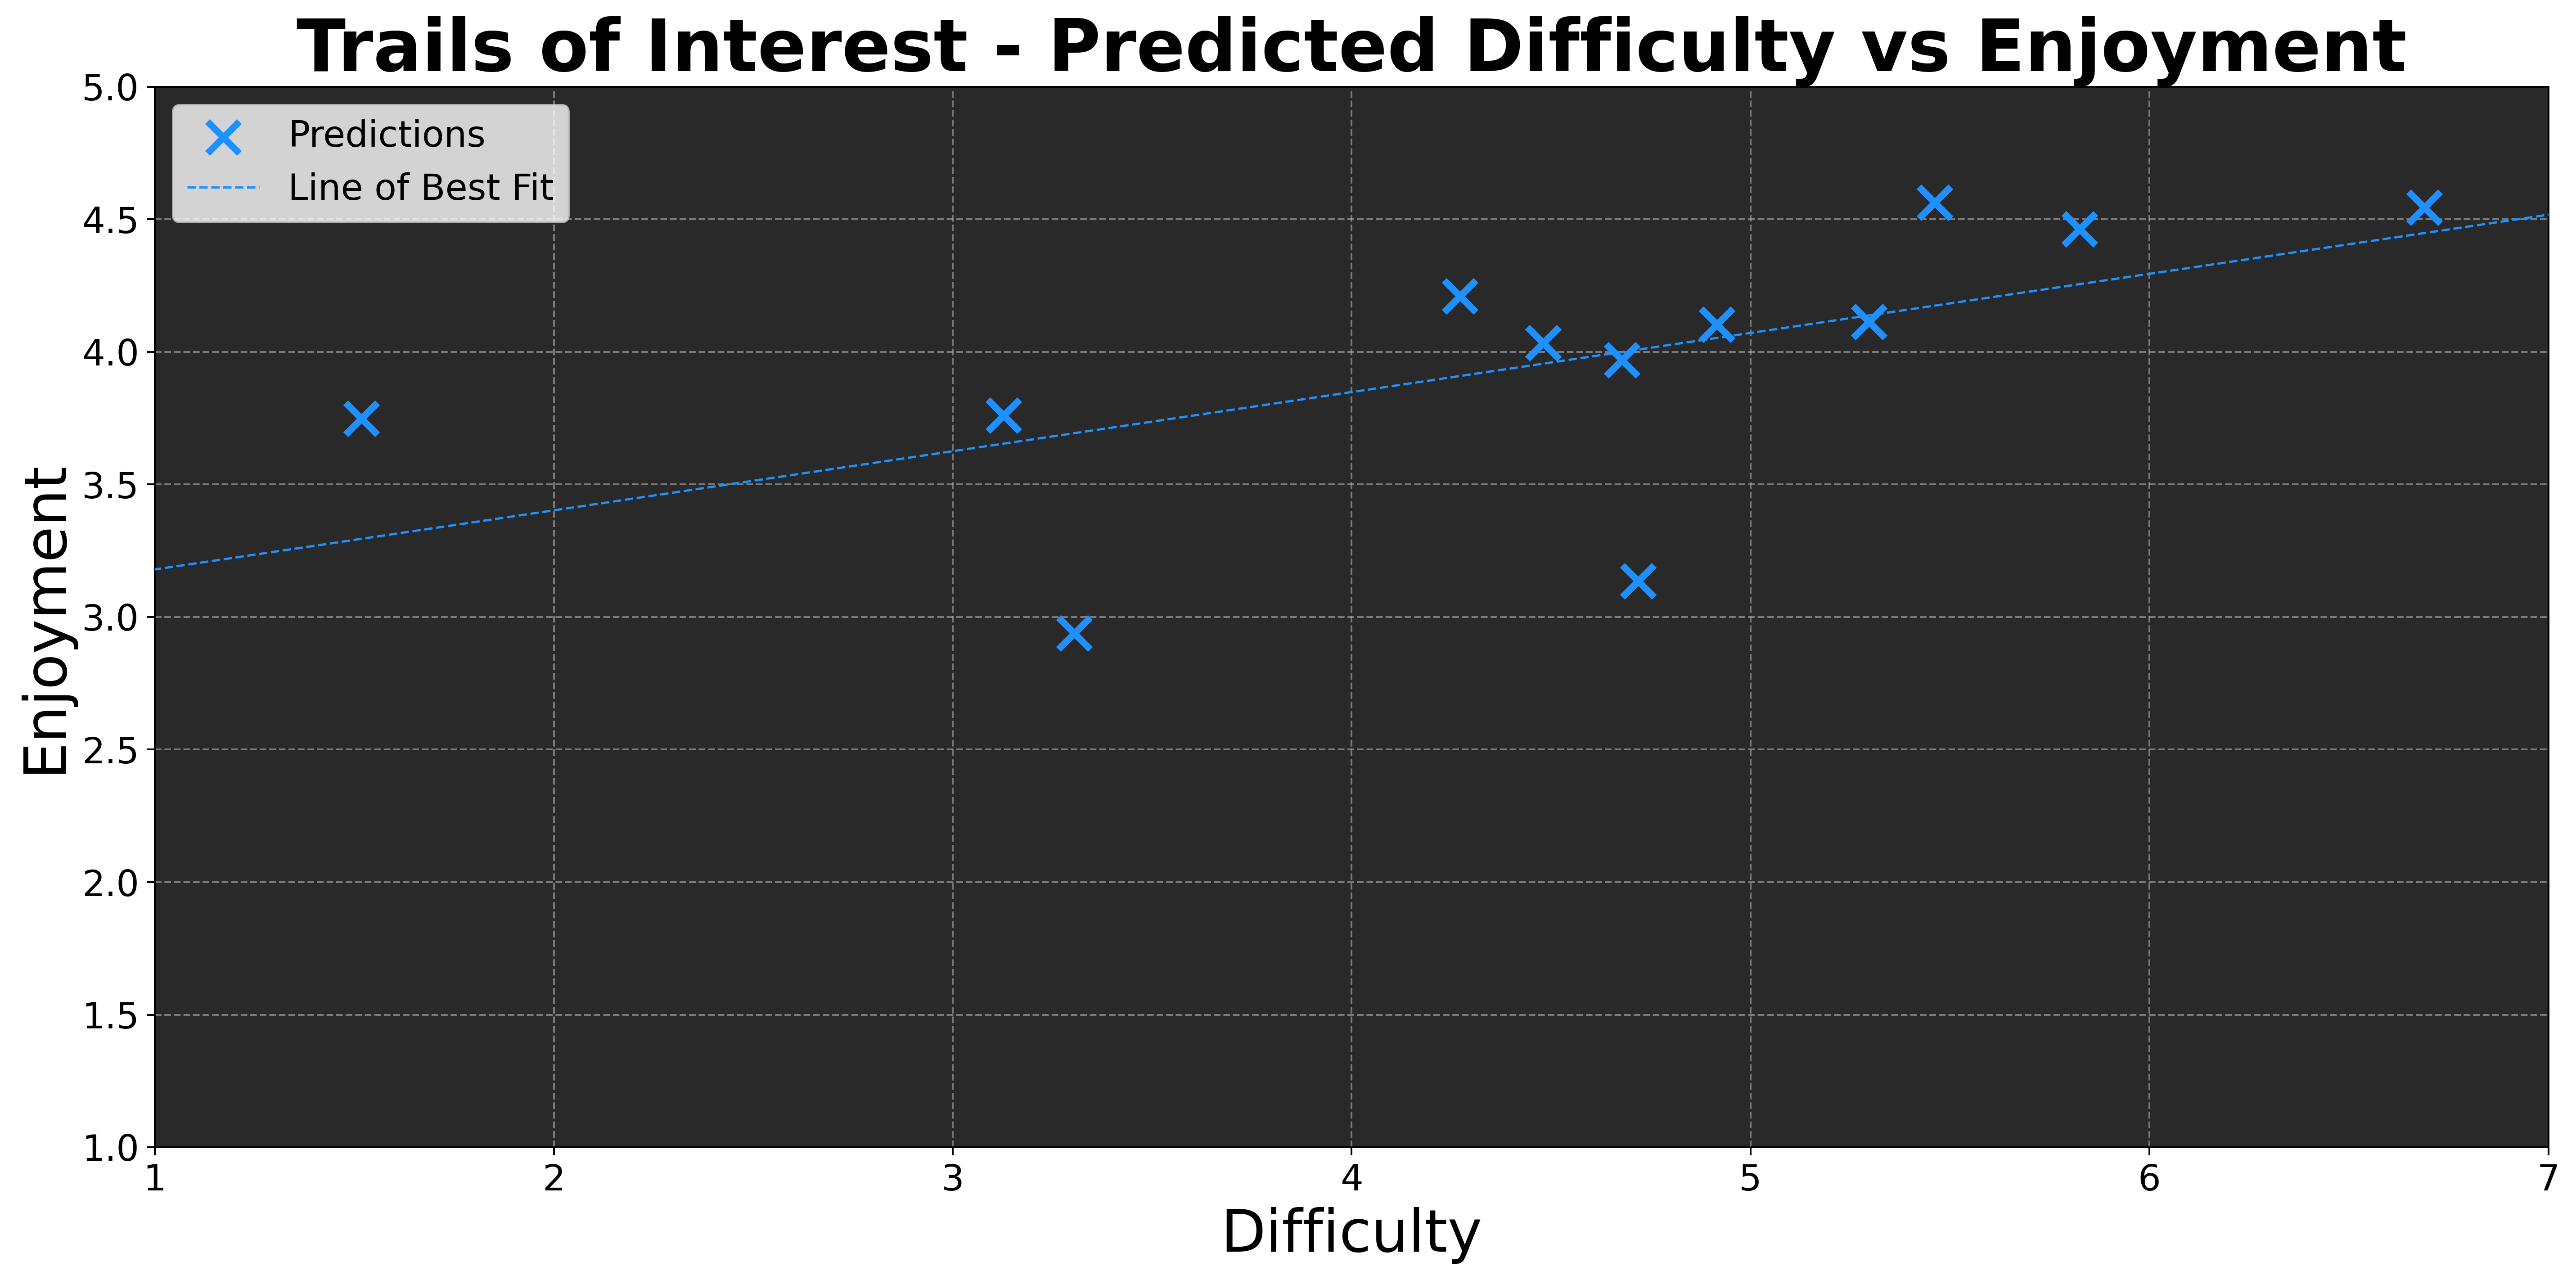

In [68]:
fig = plt.figure(figsize=(standardCanvasWidth, standardCanvasHeight), dpi=DPI)
plt.rcParams["axes.facecolor"] = backgroundColor

# Prediction scatter plot
sns.scatterplot(data=interestTrails, 
                x="difficulty", 
                y="enjoyment", 
                marker="x", 
                linewidths=3, 
                color="dodgerblue",
                s=200, 
                zorder=2, 
                label="Predictions")

# Line of best fit
z = np.polyfit(interestTrails["difficulty"], interestTrails["enjoyment"], 1)
p = np.poly1d(z)

plt.plot(np.linspace(0, 8, 10), p(np.linspace(0, 8, 10)), 
         c="dodgerblue" ,ls="--", lw=1, zorder=3, label="Line of Best Fit")

plt.xlim(1, 7)
plt.ylim(1, 5)

plotTitle = "Trails of Interest - Predicted Difficulty vs Enjoyment"
plt.title(plotTitle, size=titleSize, fontweight="bold")
plt.xlabel("Difficulty", size=axisLabelSize)
plt.ylabel("Enjoyment", size=axisLabelSize)

plt.legend(facecolor=legendColor, prop={"size": legendTextSize}, loc="upper left")

plt.tick_params(axis="both", labelsize=tickLabelSize)
plt.grid(True, ls="--", alpha=0.6, zorder=1)

fig.patch.set_facecolor("w")
plt.tight_layout()
plt.savefig(f"images/{plotTitle.replace(' ', '')}")
plt.show()

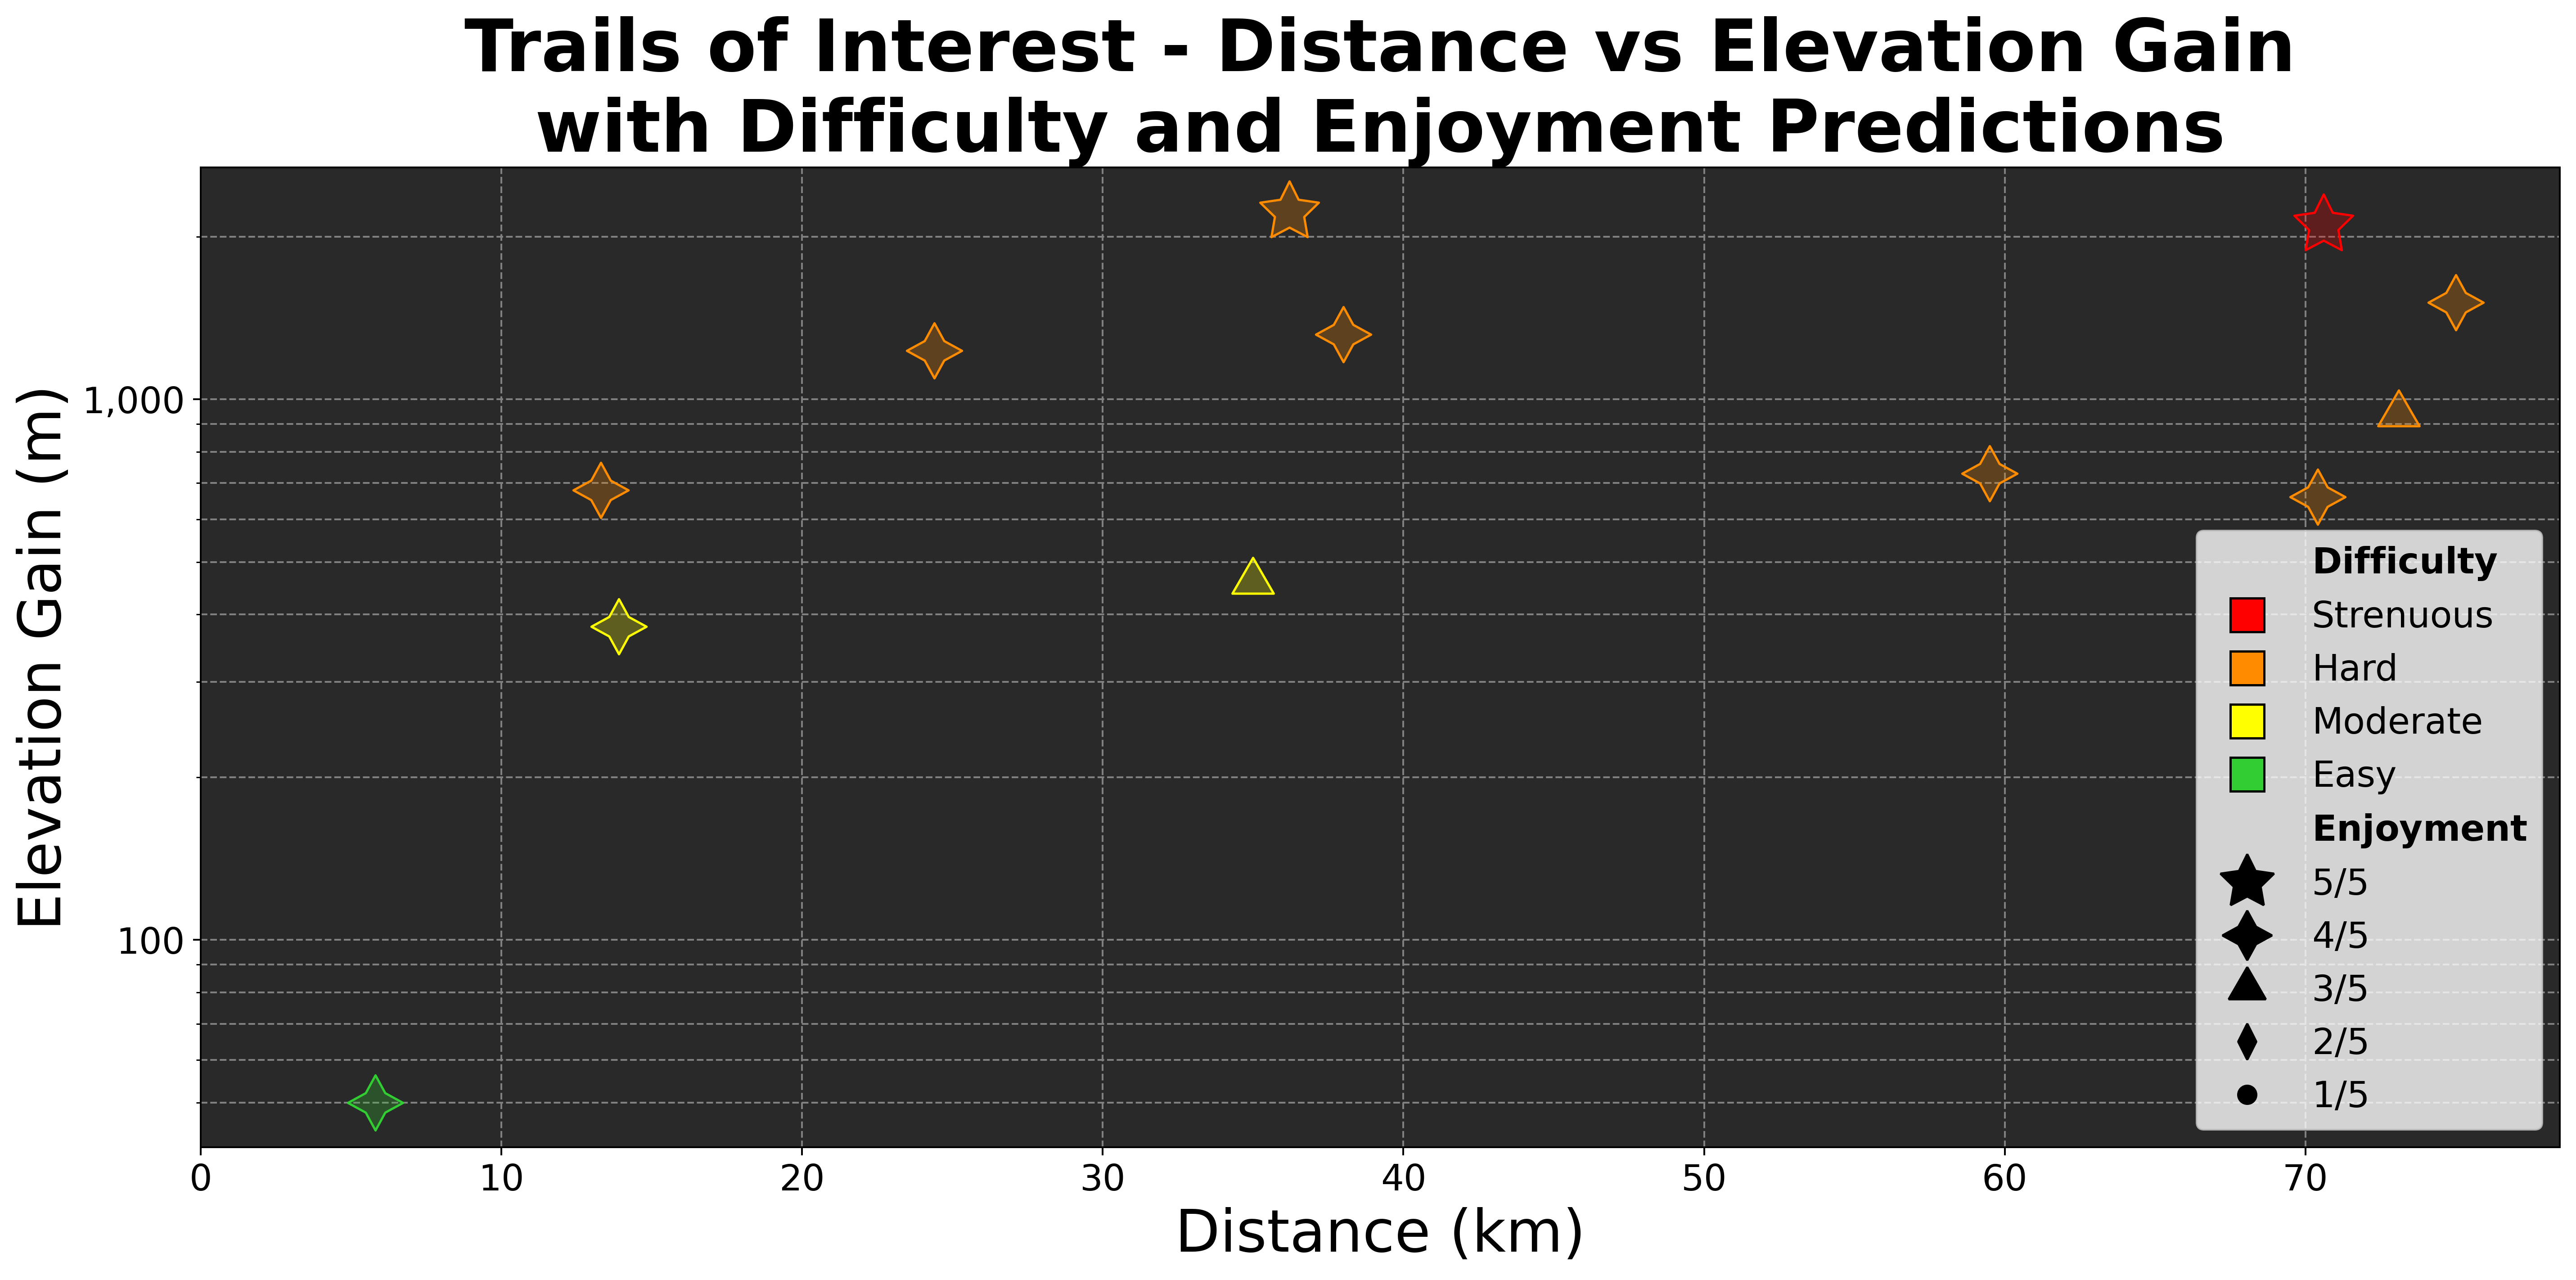

In [69]:
distGainEnjoyDiffPlot(
    "Trails of Interest - Distance vs Elevation Gain\nwith Difficulty and Enjoyment Predictions",
    "Distance (km)",
    "Elevation Gain (m)",
    interestTrails.distance, 
    interestTrails.elevation_gain, 
    roundDifficulties(interestTrails.difficulty),
    roundEnjoyments(interestTrails.enjoyment),
    savePlot=True
)